# Spin helix

In [1]:
import numpy as np
from functools import lru_cache

from scipy.integrate import trapezoid, simpson, romb 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm

plt.style.use("paper_plot_style.mplstyle")

In [2]:
def _d_terms(KX, KY, Kx, Kz, qx, qy, symmetry):
    """
    Return (d1, d3) for given k components.
    KX, KY can be scalars or numpy arrays of same shape.
    """
    d1 = 0.5 * Kx * (qx * KX + qy * KY)

    if symmetry == "d-wave":
        d3 = 0.5 * Kz * (KX * KY + 0.5 * qx * qy)

    elif symmetry == "g-wave":
        d3 = (
            Kz / 24.0
            * (
                KX * KY * (KX**2 - KY**2)
                - (3.0 / 16.0) * qx * qy * (KY**2 - KX**2)
                + (3.0 / 16.0) * (qx**2 - qy**2) * KX * KY
            )
        )
    else:
        raise ValueError("symmetry must be 'd-wave' or 'g-wave'.")

    return d1, d3


def energies_and_tau3_at_k(kx, ky, m, Kx, Kz, qx, qy, symmetry, rtol_node=1e-14):
    """
    Pointwise energies and tau3 expectation for the ± bands.
    Scalar-safe and array-safe.
    """
    eps0 = (kx**2 + ky**2 + 0.25 * (qx**2 + qy**2)) / (2.0 * m)
    d1, d3 = _d_terms(kx, ky, Kx, Kz, qx, qy, symmetry)
    R = np.sqrt(d1**2 + d3**2)

    tau3_plus = np.divide(d3, R, out=np.zeros_like(R), where=(R > rtol_node))
    tau3_minus = -tau3_plus

    Eplus = eps0 + R
    Eminus = eps0 - R
    return Eplus, Eminus, tau3_plus, tau3_minus


def spectral_map(kmax, N, m, Kx, Kz, q, phi_q, mu, eta, symmetry):
    """
    Z(k) = A+(k)*tau3+(k) + A-(k)*tau3-(k) on a regular grid (for visualization).
    """
    qx, qy = q * np.cos(phi_q), q * np.sin(phi_q)

    kx = np.linspace(-kmax, kmax, N)
    ky = np.linspace(-kmax, kmax, N)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")

    Eplus, Eminus, t3p, t3m = energies_and_tau3_at_k(KX, KY, m, Kx, Kz, qx, qy, symmetry)

    Lp = eta / np.pi / ((mu - Eplus) ** 2 + eta**2)
    Lm = eta / np.pi / ((mu - Eminus) ** 2 + eta**2)

    Z = Lp * t3p + Lm * t3m
    return kx, ky, Z


def spin_helix_quiver(Lx, Ly, M, q, phi_q):
    qx, qy = q * np.cos(phi_q), q * np.sin(phi_q)
    x = np.linspace(0, Lx, M)
    y = np.linspace(0, Ly, M)
    X, Y = np.meshgrid(x, y, indexing="xy")
    phase = qx * X + qy * Y
    U = np.cos(phase)
    V = np.sin(phase)
    return X, Y, U, V


# -----------------------------------------------------------------------------
# Analytic velocities
# -----------------------------------------------------------------------------
def _grad_eps0(kx, ky, m):
    return (kx / m, ky / m)


def _grad_d1(kx, ky, Kx, qx, qy):
    return (0.5 * Kx * qx, 0.5 * Kx * qy)


def _grad_d3(kx, ky, Kz, qx, qy, symmetry):
    if symmetry == "d-wave":
        return (0.5 * Kz * ky, 0.5 * Kz * kx)

    if symmetry == "g-wave":
        pref = Kz / 24.0
        dt1_dkx = 3.0 * kx**2 * ky - ky**3
        dt1_dky = kx**3 - 3.0 * kx * ky**2
        dt2_dkx = (3.0 / 8.0) * qx * qy * kx
        dt2_dky = -(3.0 / 8.0) * qx * qy * ky
        dt3_dkx = (3.0 / 16.0) * (qx**2 - qy**2) * ky
        dt3_dky = (3.0 / 16.0) * (qx**2 - qy**2) * kx
        dd3_dkx = pref * (dt1_dkx + dt2_dkx + dt3_dkx)
        dd3_dky = pref * (dt1_dky + dt2_dky + dt3_dky)
        return (dd3_dkx, dd3_dky)

    raise ValueError("symmetry must be 'd-wave' or 'g-wave'.")


def velocities_at_k(kx, ky, m, Kx, Kz, qx, qy, symmetry, rtol_node=1e-14):
    """
    Analytic group velocities for E± at point(s) (kx,ky).
    Scalar-safe and array-safe.
    """
    d1, d3 = _d_terms(kx, ky, Kx, Kz, qx, qy, symmetry)
    R = np.sqrt(d1**2 + d3**2)

    deps_dkx, deps_dky = _grad_eps0(kx, ky, m)
    dd1_dkx, dd1_dky = _grad_d1(kx, ky, Kx, qx, qy)
    dd3_dkx, dd3_dky = _grad_d3(kx, ky, Kz, qx, qy, symmetry)

    dR_dkx = np.divide(d1 * dd1_dkx + d3 * dd3_dkx, R, out=np.zeros_like(R), where=(R > rtol_node))
    dR_dky = np.divide(d1 * dd1_dky + d3 * dd3_dky, R, out=np.zeros_like(R), where=(R > rtol_node))

    vx_plus  = deps_dkx + dR_dkx
    vy_plus  = deps_dky + dR_dky
    vx_minus = deps_dkx - dR_dkx
    vy_minus = deps_dky - dR_dky

    return vx_plus, vy_plus, vx_minus, vy_minus

def _lorentz(mu, E, eta):
    return eta / np.pi / ((mu - E) ** 2 + eta**2)


def d_fields_np(KX, KY, *, Kx, Kz, qx, qy, symmetry):
    d1, d3 = _d_terms(KX, KY, Kx, Kz, qx, qy, symmetry)
    d1x, d1y = _grad_d1(KX, KY, Kx, qx, qy)              # broadcasts OK
    d3x, d3y = _grad_d3(KX, KY, Kz, qx, qy, symmetry)     # arrays
    return d1, d3, d1x, d1y, d3x, d3y

def v_interband_np(alpha, d1, d3, d1x, d1y, d3x, d3y, R, rtol=1e-14):
    # v^{+-}_α = (d3 ∂α d1 - d1 ∂α d3) / R^2
    if alpha == "x":
        num = d3 * d1x - d1 * d3x
    elif alpha == "y":
        num = d3 * d1y - d1 * d3y
    else:
        raise ValueError("alpha must be 'x' or 'y'")
    out = np.zeros_like(R, dtype=np.float64)
    mask = R > rtol
    out[mask] = num[mask] / (R[mask] ** 2)
    return out


def _kubo_weight_map(*, omega0, eta_omega, R):
    """
    Positive absorption-like weight consistent with Im[ ω / ((ω+iη)^2 - 4R^2) ] up to prefactors.
    W_Kubo = 2 ω^2 η / [ (ω^2 - η^2 - 4R^2)^2 + (2 ω η)^2 ].
    """
    R2 = R * R
    num = 2.0 * (omega0 * omega0) * eta_omega
    den = (omega0 * omega0 - eta_omega * eta_omega - 4.0 * R2) ** 2 + (2.0 * omega0 * eta_omega) ** 2
    return num / (den + 1e-30)

In [3]:
# -------------------------------
# Cached polar grid on the disk
# -------------------------------
@lru_cache(maxsize=16)
def _polar_grid_cached(kmax, Nr, Nth, r_power):
    """
    Returns (r, th, R, TH, kx, ky) for a polar grid on the disk.
    r_power < 1 clusters points near kmax (often good for FS features).
    r_power > 1 clusters near r=0.
    """
    r  = kmax * (np.linspace(0.0, 1.0, Nr) ** r_power)
    th = np.linspace(0.0, 2.0*np.pi, Nth, endpoint=False)

    # shapes: (Nth, Nr)
    R, TH = np.meshgrid(r, th, indexing="xy")
    c, s  = np.cos(TH), np.sin(TH)
    kx = R * c
    ky = R * s
    return r, th, R, TH, kx, ky


# -----------------------------------------------------------------------------
# DC conductivity tensor (fast numeric quadrature on a polar grid)
# -----------------------------------------------------------------------------
def conductivity_tensor(
    m, Kx, Kz, q, phi_q, mu, eta, kmax, symmetry,
    Nr=2000, Nth=720, r_power=1,
):
    """
    Fast approximation:
      σ_ij ≈ (1/(2η(2π)^2)) ∫_{|k|≤kmax} d^2k [A+(k) v_i^+ v_j^+ + A-(k) v_i^- v_j^-]

    Numerical quadrature on a polar grid:
      ∫ d^2k f(k) = ∫_0^{2π} dθ ∫_0^{kmax} dr (r f(r,θ))

    Tunables:
      Nr, Nth: radial and angular resolution
      r_power: radial stretching (default <1 clusters near kmax)
    """
    qx, qy = q*np.cos(phi_q), q*np.sin(phi_q)

    r, th, R, TH, kx, ky = _polar_grid_cached(float(kmax), int(Nr), int(Nth), float(r_power))

    Eplus, Eminus, _, _ = energies_and_tau3_at_k(kx, ky, m, Kx, Kz, qx, qy, symmetry)
    vx_p, vy_p, vx_m, vy_m = velocities_at_k(kx, ky, m, Kx, Kz, qx, qy, symmetry)

    Aplus  = _lorentz(mu, Eplus,  eta)
    Aminus = _lorentz(mu, Eminus, eta)

    Ixx = Aplus * vx_p * vx_p + Aminus * vx_m * vx_m
    Iyy = Aplus * vy_p * vy_p + Aminus * vy_m * vy_m
    Ixy = Aplus * vx_p * vy_p + Aminus * vx_m * vy_m

    # Integrate on disk: ∫ dθ ∫ dr (r * I)
    # arrays are (Nth, Nr): integrate over r (axis=1) then theta (axis=0)
    def integrate_disk(F, R, r, Nth):
    # integrate in r (nonuniform): ok to trapz
      Fr = trapezoid(F * R, r, axis=1)          # shape (Nth,)
      dtheta = 2.0*np.pi / Nth
      return dtheta * np.sum(Fr)      # integrate in theta

    Ixx_int = integrate_disk(Ixx, R, r, Nth)
    Iyy_int = integrate_disk(Iyy, R, r, Nth)
    Ixy_int = integrate_disk(Ixy, R, r, Nth)
    
    pref = 1.0 / (2.0 * eta * (2.0 * np.pi) ** 2)
    sigma_xx = pref * Ixx_int
    sigma_yy = pref * Iyy_int
    sigma_xy = pref * Ixy_int
    sigma_yx = sigma_xy

    return sigma_xx, sigma_yy, sigma_xy, sigma_yx


In [4]:
inv_2pi2 = 1.0 / (2.0 * np.pi)**2
e_charge = 1.0

def _fermi_vec(E, mu, T, clip=50.0):
    """
    Vectorized Fermi-Dirac with clipping.
    k_B = 1 convention. For T<=0 returns step(E<mu).
    """
    if T is None or T <= 0.0:
        return (E < mu).astype(np.float64)

    x = (E - mu) / T
    x = np.clip(x, -clip, clip)
    return 1.0 / (np.exp(x) + 1.0)


def _interband_v_np(KX, KY, Kx, Kz, qx, qy, symmetry, rtol_node=1e-14):
    """
    Vectorized interband velocities v^{+-}_x, v^{+-}_y and R2 on a grid.

    v^{+-}_α = (d3 ∂α d1 - d1 ∂α d3) / R^2
    """
    d1, d3 = _d_terms(KX, KY, Kx, Kz, qx, qy, symmetry)
    R2 = d1*d1 + d3*d3

    d1x, d1y = _grad_d1(KX, KY, Kx, qx, qy)          # scalars (or broadcast)
    d3x, d3y = _grad_d3(KX, KY, Kz, qx, qy, symmetry) # arrays

    vx = np.zeros_like(R2, dtype=np.float64)
    vy = np.zeros_like(R2, dtype=np.float64)

    mask = R2 > (rtol_node**2)
    vx[mask] = (d3[mask]*d1x - d1[mask]*d3x[mask]) / R2[mask]
    vy[mask] = (d3[mask]*d1y - d1[mask]*d3y[mask]) / R2[mask]
    return vx, vy, R2


def precompute_Pi_kernel_polar(
    *,
    m, Kx, Kz, qx, qy, symmetry,
    mu, T,
    kmax=3.0,
    Nk=1500,
    Ntheta=720,
    use_pi_symmetry=True,
    rtol_node=1e-14,
    occ_tol=0.0,
):
    """
    Precompute k-dependent kernel pieces on a fixed polar grid.

    Returns a dict with flattened arrays:
      R2_flat, Kxx_flat, Kyy_flat, Kxy_flat

    where Kαβ already includes:
      Kαβ = (2 * occ * vα * vβ) * (Jacobian k) * (quadrature weight dk dθ)
    """
    # grids
    k = np.linspace(0.0, kmax, Nk)
    dk = k[1] - k[0]

    if use_pi_symmetry:
        theta = np.linspace(0.0, np.pi, Ntheta, endpoint=False)
        theta_factor = 2.0
        dtheta = np.pi / Ntheta
    else:
        theta = np.linspace(0.0, 2.0*np.pi, Ntheta, endpoint=False)
        theta_factor = 1.0
        dtheta = 2.0*np.pi / Ntheta

    kk = k[:, None]                       # (Nk,1)
    ct = np.cos(theta)[None, :]           # (1,Nθ)
    st = np.sin(theta)[None, :]           # (1,Nθ)

    KX = kk * ct                          # (Nk,Nθ)
    KY = kk * st

    # band ingredients
    eps0 = (KX*KX + KY*KY + 0.25*(qx*qx + qy*qy)) / (2.0*m)

    vx, vy, R2 = _interband_v_np(KX, KY, Kx, Kz, qx, qy, symmetry, rtol_node=rtol_node)
    R = np.sqrt(R2)

    E_plus  = eps0 + R
    E_minus = eps0 - R

    occ = _fermi_vec(E_minus, mu, T) - _fermi_vec(E_plus, mu, T)
    if occ_tol > 0.0:
        occ = np.where(np.abs(occ) > occ_tol, occ, 0.0)

    w = theta_factor * (kk * dk * dtheta)  # (Nk,Nθ)

    # build kernels
    pref = 2.0 * occ * w
    Kxx = pref * (vx * vx)
    Kyy = pref * (vy * vy)
    Kxy = pref * (vx * vy)

    # flatten for fast ω-evaluation
    return {
        "R2":  R2.reshape(-1),
        "Kxx": Kxx.reshape(-1),
        "Kyy": Kyy.reshape(-1),
        "Kxy": Kxy.reshape(-1),
        "meta": dict(Nk=Nk, Ntheta=Ntheta, kmax=kmax, use_pi_symmetry=use_pi_symmetry,
                     dk=dk, dtheta=dtheta, theta_factor=theta_factor)
    }


def Pi_from_kernel_many_omega(*, omegas, eta, kernel, component="xx"):
    """
    Evaluate Π_ab(ω) for many ω from precomputed kernel.

    component in {"xx","yy","xy"}.
    Returns complex array shape (Nω,).
    """
    omegas = np.asarray(omegas, dtype=np.float64)
    omega_c2 = (omegas + 1j*eta)**2  # (Nω,)

    R2 = kernel["R2"][None, :]       # (1,Np)
    if component == "xx":
        K = kernel["Kxx"][None, :]
    elif component == "yy":
        K = kernel["Kyy"][None, :]
    elif component == "xy":
        K = kernel["Kxy"][None, :]
    else:
        raise ValueError("component must be 'xx', 'yy', or 'xy'.")

    denom = omega_c2[:, None] - 4.0 * R2                  # (Nω,Np)
    S = np.sum(K / denom, axis=1)                         # (Nω,)
    Pi = -(e_charge**2) * inv_2pi2 * (omegas * S)         # (Nω,)
    return Pi


def Pi_tensor_many_omega(*, omegas, eta, kernel):
    """
    Convenience: return Π_xx, Π_yy, Π_xy arrays (all shape Nω).
    """
    Pxx = Pi_from_kernel_many_omega(omegas=omegas, eta=eta, kernel=kernel, component="xx")
    Pyy = Pi_from_kernel_many_omega(omegas=omegas, eta=eta, kernel=kernel, component="yy")
    Pxy = Pi_from_kernel_many_omega(omegas=omegas, eta=eta, kernel=kernel, component="xy")
    return Pxx, Pyy, Pxy


In [5]:
def principal_axes_from_M(Mxx, Myy, Mxy, *, unwrap_axis=None):
    """
    Principal axes + dichroism diagnostics for a real symmetric 2x2 tensor

        M = [[Mxx, Mxy],
             [Mxy, Myy]]

    Returns:
        theta_plus : angle (rad) of the eigenvector associated with sigma_plus (largest eigenvalue)
                     defined modulo pi (axis direction).
        sigma_plus : largest eigenvalue
        sigma_minus: smallest eigenvalue
        A          : total absorption proxy = sigma_plus + sigma_minus = tr(M)
        D          : linear dichroism proxy = (sigma_plus - sigma_minus) / (sigma_plus + sigma_minus)

    Notes:
        - Uses direct diagonalization (np.linalg.eigh) for numerical stability.
        - If Mxx, Myy, Mxy are arrays, outputs are arrays with broadcasted shape.
        - unwrap_axis: if not None, unwrap theta_plus along this axis with period pi.
    """
    Mxx = (np.asarray(Mxx)).real
    Myy = (np.asarray(Myy)).real
    Mxy = (np.asarray(Mxy)).real

    # Build (..., 2, 2) matrix with broadcasting
    M = np.empty(Mxx.shape + (2, 2), dtype=np.result_type(Mxx, Myy, Mxy, float))
    M[..., 0, 0] = Mxx
    M[..., 1, 1] = Myy
    M[..., 0, 1] = Mxy
    M[..., 1, 0] = Mxy

    # Eigen-decomposition for symmetric matrices: eigenvalues are sorted ascending
    evals, evecs = np.linalg.eigh(M)   # evals[...,0]=small, evals[...,1]=large

    sigma_minus = evals[..., 0]
    sigma_plus  = evals[..., 1]

    # Eigenvector corresponding to sigma_plus is last column
    v = evecs[..., :, 1]               # (..., 2)
    vx = v[..., 0]
    vy = v[..., 1]

    # Axis angle in [0, pi) (because v and -v represent the same axis)
    theta_plus = np.mod(np.arctan2(vy, vx), np.pi)

    # Optional unwrapping along a chosen axis (period pi)
    if unwrap_axis is not None:
        theta_plus = np.unwrap(theta_plus, axis=unwrap_axis, period=np.pi)
        theta_plus = np.mod(theta_plus, np.pi)

    A = sigma_plus + sigma_minus
    # Avoid divide-by-zero blowups when A ~ 0
    eps = np.finfo(np.result_type(A, float)).eps
    D = (sigma_plus - sigma_minus) / np.where(np.abs(A) > eps, A, np.nan)

    return theta_plus, sigma_plus, sigma_minus, A, D

## Parameters

In [6]:
params = {
    "d-wave": dict(
        m=1.0,
        Kz=0.3,
        Kx=1.0,
        mu=3,
        eta=0.03,
        kmax=4,
        symmetry="d-wave",
    ),
    "g-wave": dict(
        m=1.0,
        Kz=0.5,
        Kx=1.0,
        mu=3,
        eta=0.02,
        kmax=4,
        symmetry="g-wave",
    ),
}

q = 0.2

## Fermi surface

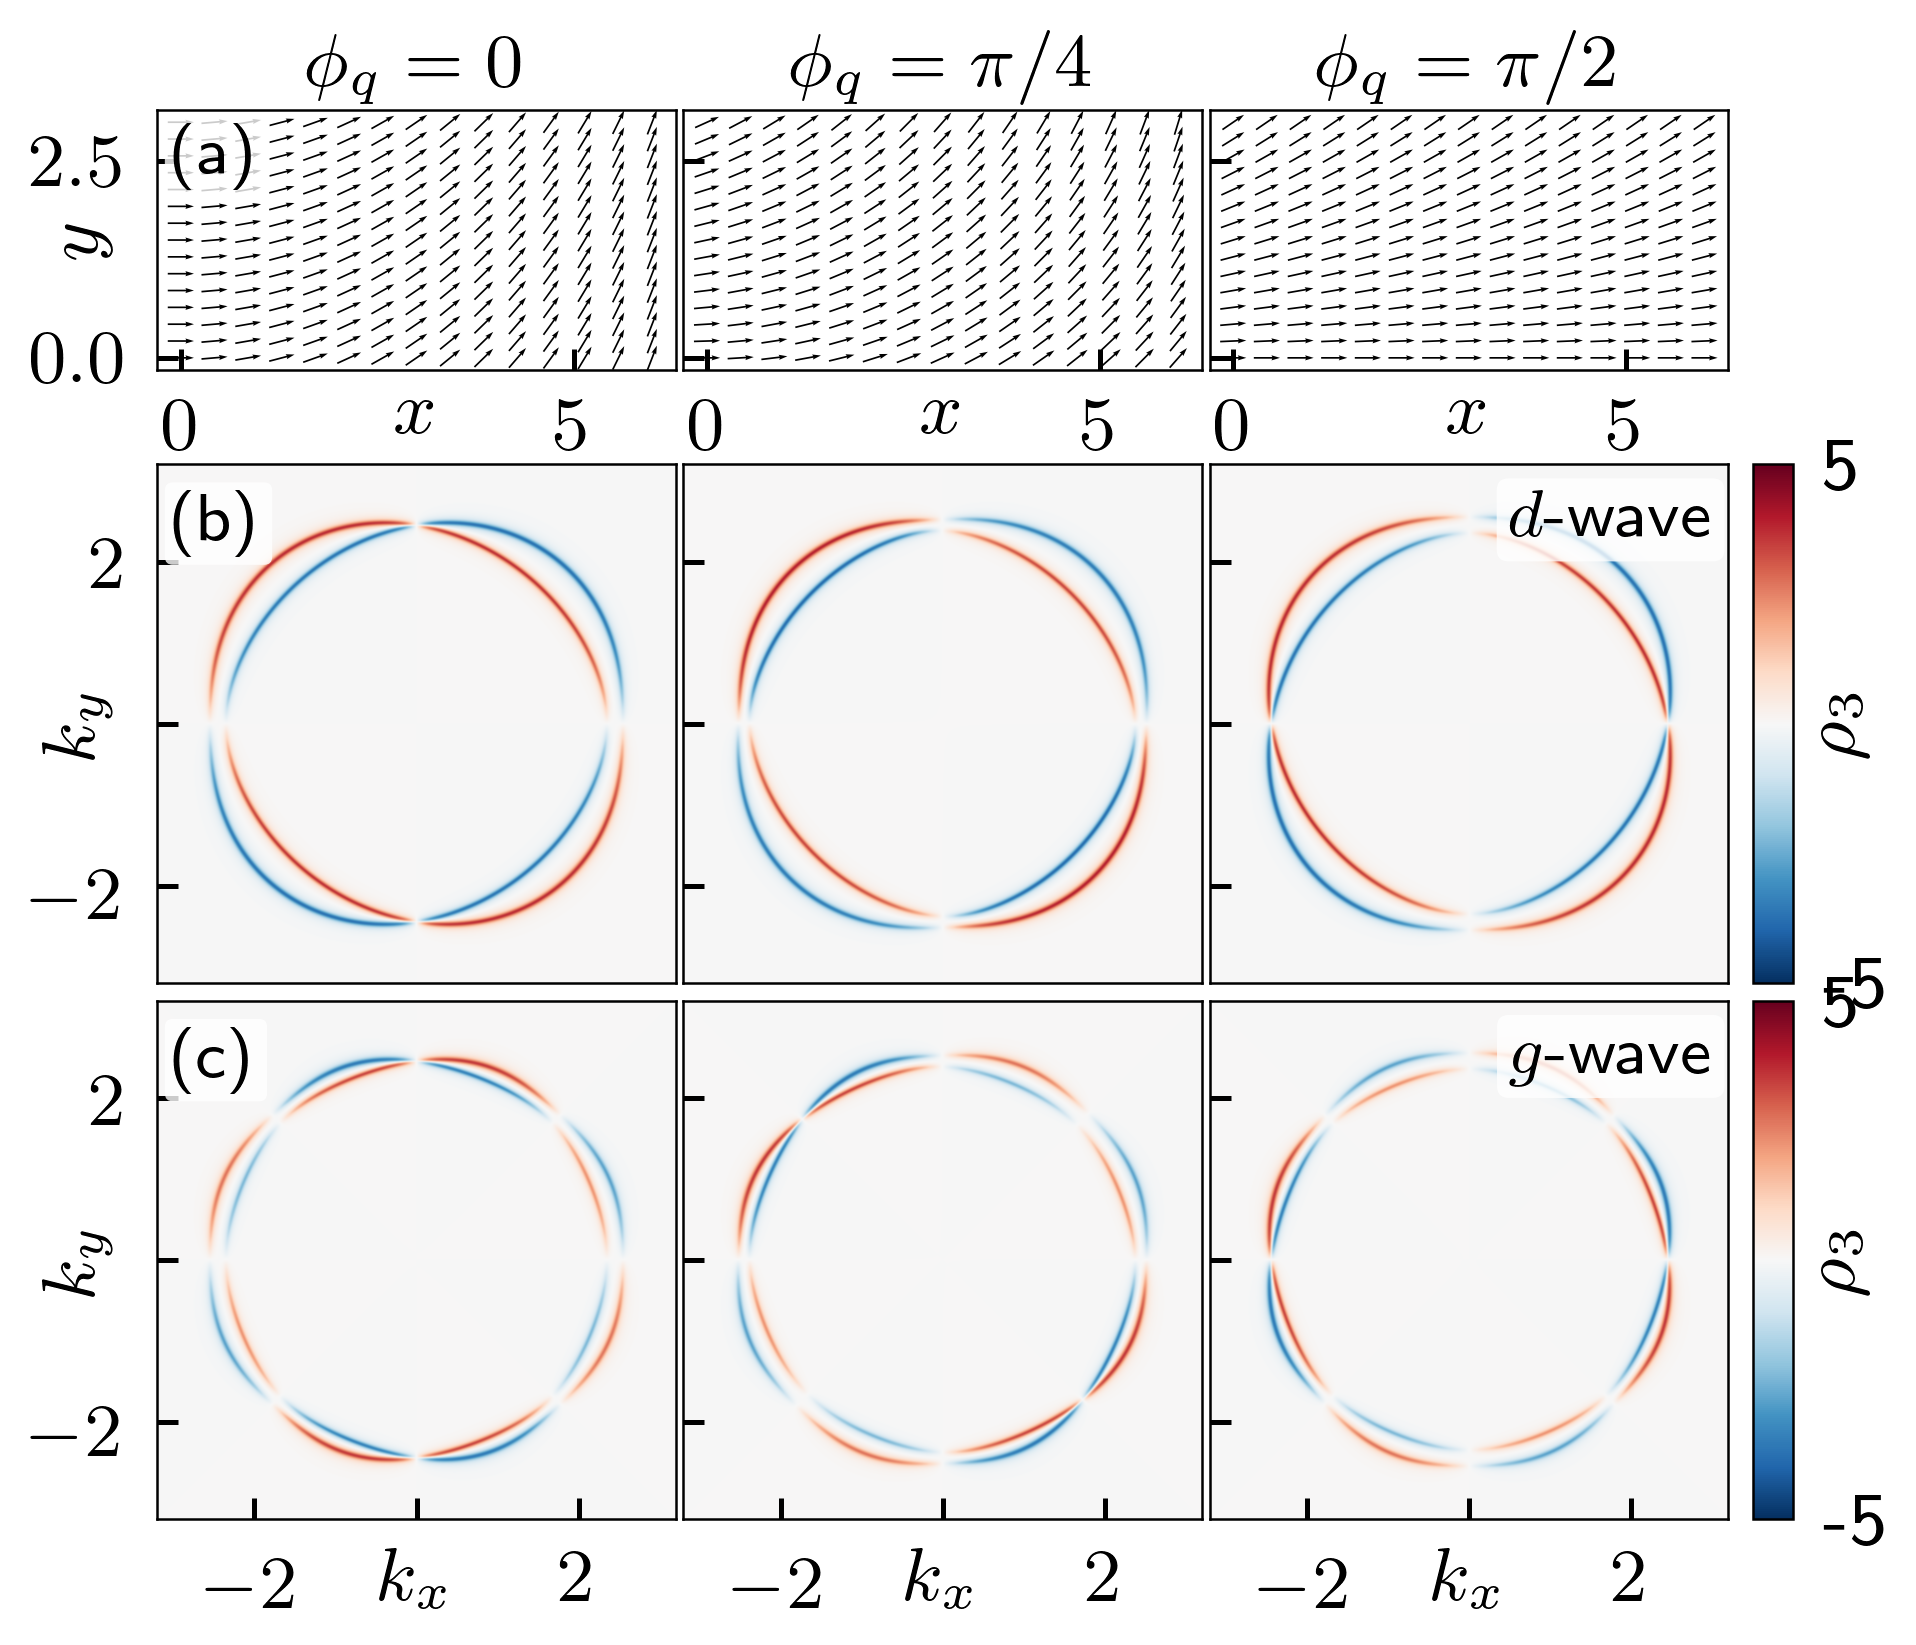

In [7]:
def fig_spin_vs_spectral_dwave_gwave_gridspec(
    params_d,
    params_g,
    *,
    q,
    kmax,
    Nk,
    figsize=(3.4, 4.5),
    cbar_lim=15.0,
    Lx=6,
    Ly=3,
    M=15,
    eta=0.03,
):
    phis = [0.0, np.pi / 4, np.pi / 2]
    col_titles = [r"$\phi_q=0$", r"$\phi_q=\pi/4$", r"$\phi_q=\pi/2$"]

    # -------------------------
    # Precompute spectral maps
    # -------------------------
    spec_d, spec_g = [], []
    for phi in phis:
        kx, ky, Zd = spectral_map(
            kmax=kmax, N=Nk,
            m=params_d["m"], Kx=params_d["Kx"], Kz=params_d["Kz"],
            q=q, phi_q=phi, mu=params_d["mu"], eta=eta,
            symmetry=params_d["symmetry"],
        )
        spec_d.append((kx, ky, Zd))

        kx2, ky2, Zg = spectral_map(
            kmax=kmax, N=Nk,
            m=params_g["m"], Kx=params_g["Kx"], Kz=params_g["Kz"],
            q=q, phi_q=phi, mu=params_g["mu"], eta=eta,
            symmetry=params_g["symmetry"],
        )
        spec_g.append((kx2, ky2, Zg))

    vmin, vmax = -cbar_lim, cbar_lim

    # -------------------------
    # Layout
    # -------------------------
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    gs = gridspec.GridSpec(
        nrows=3,
        ncols=3,
        figure=fig,
        height_ratios=[0.8, 1.0, 1.0], 
        wspace=0.015,
        hspace=0.015,  
    )

    ax_top = [fig.add_subplot(gs[0, i]) for i in range(3)]
    ax_mid = [fig.add_subplot(gs[1, i]) for i in range(3)]
    ax_bot = [fig.add_subplot(gs[2, i]) for i in range(3)]

    # Leave room for two vertical colorbars at the right
    fig.subplots_adjust(left=0.09, right=0.86, bottom=0.10, top=0.96)

    # -------------------------
    # (a) Top row: quiver
    # -------------------------
    for c, phi in enumerate(phis):
        ax = ax_top[c]
        X, Y, U, V = spin_helix_quiver(Lx=Lx, Ly=Ly, M=M, q=q, phi_q=phi)
        ax.quiver(
            X, Y, U, V,
            pivot="mid",
            angles="xy",
            scale_units="xy",
            scale=3.0,
            width=0.0033,
            color="k",
        )
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(col_titles[c], pad=3)

        # panel tag
        if c == 0:
            ax.text(
                0.03, 0.95, r"(a)",
                transform=ax.transAxes,
                ha="left", va="top",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.80),
            )
            ax.set_ylabel(r"$y$", labelpad=-10)
        else:
            ax.set_yticklabels([])

        ax.set_xlabel(r"$x$", labelpad=-10)

    # -------------------------
    # Helper to draw spectral rows
    # -------------------------
    def draw_spectral_row(ax_row, spec_row, panel_tag, *, hide_x=False, lims=None):
        last_im = None
        for c, (kx, ky, Z) in enumerate(spec_row):
            ax = ax_row[c]
            im = ax.imshow(
                Z,
                origin="lower",
                extent=[kx.min(), kx.max(), ky.min(), ky.max()],
                vmin=vmin, vmax=vmax,
                cmap="RdBu_r",
                interpolation="bicubic",
                aspect="equal",
                rasterized=True,
            )
            last_im = im

            # panel tag on the leftmost plot of the row
            if c == 0:
                ax.text(
                    0.03, 0.95, panel_tag,
                    transform=ax.transAxes,
                    ha="left", va="top",
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.80),
                )

            # y-axis
            if c == 0:
                ax.set_ylabel(r"$k_y$", labelpad=-10)
                ax.set_yticks([-2, 0, 2], labels=[r"$-2$", "", r"$2$"])
            else:
                ax.set_yticks([-2, 0, 2], labels=["", "", ""])

            # x-axis
            if hide_x:
                ax.set_xlabel("")
                ax.set_xticks([])
            else:
                ax.set_xlabel(r"$k_x$", labelpad=-8)
                ax.set_xticks([-2, 0, 2], labels=[r"$-2$", "", r"$2$"])

            if lims is not None:
                ax.set_xlim(lims)
                ax.set_ylim(lims)

        return last_im

    # (b) d-wave row: no x-axis
    im_d = draw_spectral_row(ax_mid, spec_d, r"(b)", hide_x=True, lims=(-3.2, 3.2))

    # (c) g-wave row: keep x-axis
    im_g = draw_spectral_row(ax_bot, spec_g, r"(c)", hide_x=False, lims=(-3.2, 3.2))

    # -------------------------
    # Add "d-wave" / "g-wave" labels inside rightmost panels
    # -------------------------
    row_label_box = dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.80)

    ax_mid[-1].text(
        0.97, 0.95, r"$d$-wave",
        transform=ax_mid[-1].transAxes,
        ha="right", va="top",
        fontsize=8,
        bbox=row_label_box,
    )
    ax_bot[-1].text(
        0.97, 0.95, r"$g$-wave",
        transform=ax_bot[-1].transAxes,
        ha="right", va="top",
        fontsize=8,
        bbox=row_label_box,
    )

    # -------------------------
    # Two colorbars, fixed to [-cbar_lim, cbar_lim]
    # -------------------------
    fig.canvas.draw()  # update positions

    def add_row_cbar(im, ax_ref):
        bbox = ax_ref.get_position()
        cax = fig.add_axes([bbox.x1 + 0.012, bbox.y0, 0.020, bbox.height])
        cb = fig.colorbar(im, cax=cax, orientation="vertical")
        cb.set_label(r"$\rho_3$", labelpad=-10)
        cb.set_ticks([-cbar_lim, 0.0, cbar_lim])
        cb.set_ticklabels([f"{-cbar_lim:g}", "", f"{cbar_lim:g}"])
        cb.ax.tick_params(length=0)
        return cb

    add_row_cbar(im_d, ax_mid[-1])
    add_row_cbar(im_g, ax_bot[-1])

    return fig


# usage
fig = fig_spin_vs_spectral_dwave_gwave_gridspec(
    params_d=params["d-wave"],
    params_g=params["g-wave"],
    q=q,
    kmax=params["g-wave"]["kmax"],
    Nk=1001,
    figsize=(3.4, 2.9),
    cbar_lim=5.0,
    eta = 0.08,
)
fig.savefig("Fig2-dg_wave_spiral_FS.svg")
fig.savefig("Fig2-dg_wave_spiral_FS.pdf", dpi=800)

## DC Conductivity

In [ ]:
phi_vals = np.linspace(0, 2 * np.pi, 91)
results = {}

for sym in ["d-wave", "g-wave"]:
    p = params[sym]

    sigma_xx = []
    sigma_yy = []
    sigma_xy = []
    sigma_yx = []
    rhoA_list = []
    rhoB_list = []

    for phi in tqdm(phi_vals):

        sxx, syy, sxy, syx = conductivity_tensor(
            m=p["m"],
            Kx=p["Kx"],
            Kz=p["Kz"],
            q=q,
            phi_q=phi,
            mu=p["mu"],
            eta=p["eta"],
            kmax=p["kmax"],
            symmetry=sym,
            Nr=2000,
            Nth=360*4,
        )

        sigma_xx.append(sxx)
        sigma_yy.append(syy)
        sigma_xy.append(sxy)
        sigma_yx.append(syx)

    results[sym] = dict(
        sigma_xx=np.array(sigma_xx),
        sigma_yy=np.array(sigma_yy),
        sigma_xy=np.array(sigma_xy),
        sigma_yx=np.array(sigma_yx),
    )

  0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
phi = phi_vals
c = np.cos(phi)
s = np.sin(phi)

def rotate_sigma(res):
    s_xx = res["sigma_xx"]
    s_yy = res["sigma_yy"]
    s_xy = res["sigma_xy"]
    s_yx = res["sigma_yx"]

    sigma_par = (
        c*c * s_xx
        + s*s * s_yy
        + c*s * (s_xy + s_yx)
    )

    sigma_perp = (
        s*s * s_xx
        + c*c * s_yy
        - c*s * (s_xy + s_yx)
    )

    sigma_cross = (
        -c*s * s_xx
        + c*s * s_yy
        + c*c * s_xy
        - s*s * s_yx
    )

    return sigma_par, sigma_perp, sigma_cross

sigma_par_d, sigma_perp_d, sigma_cross_d = rotate_sigma(results["d-wave"])
sigma_par_g, sigma_perp_g, sigma_cross_g = rotate_sigma(results["g-wave"])

In [ ]:
sigma0_d = params["d-wave"]["mu"] / (2 * np.pi * params["d-wave"]["eta"])
sigma0_g = params["g-wave"]["mu"] / (2 * np.pi * params["g-wave"]["eta"])

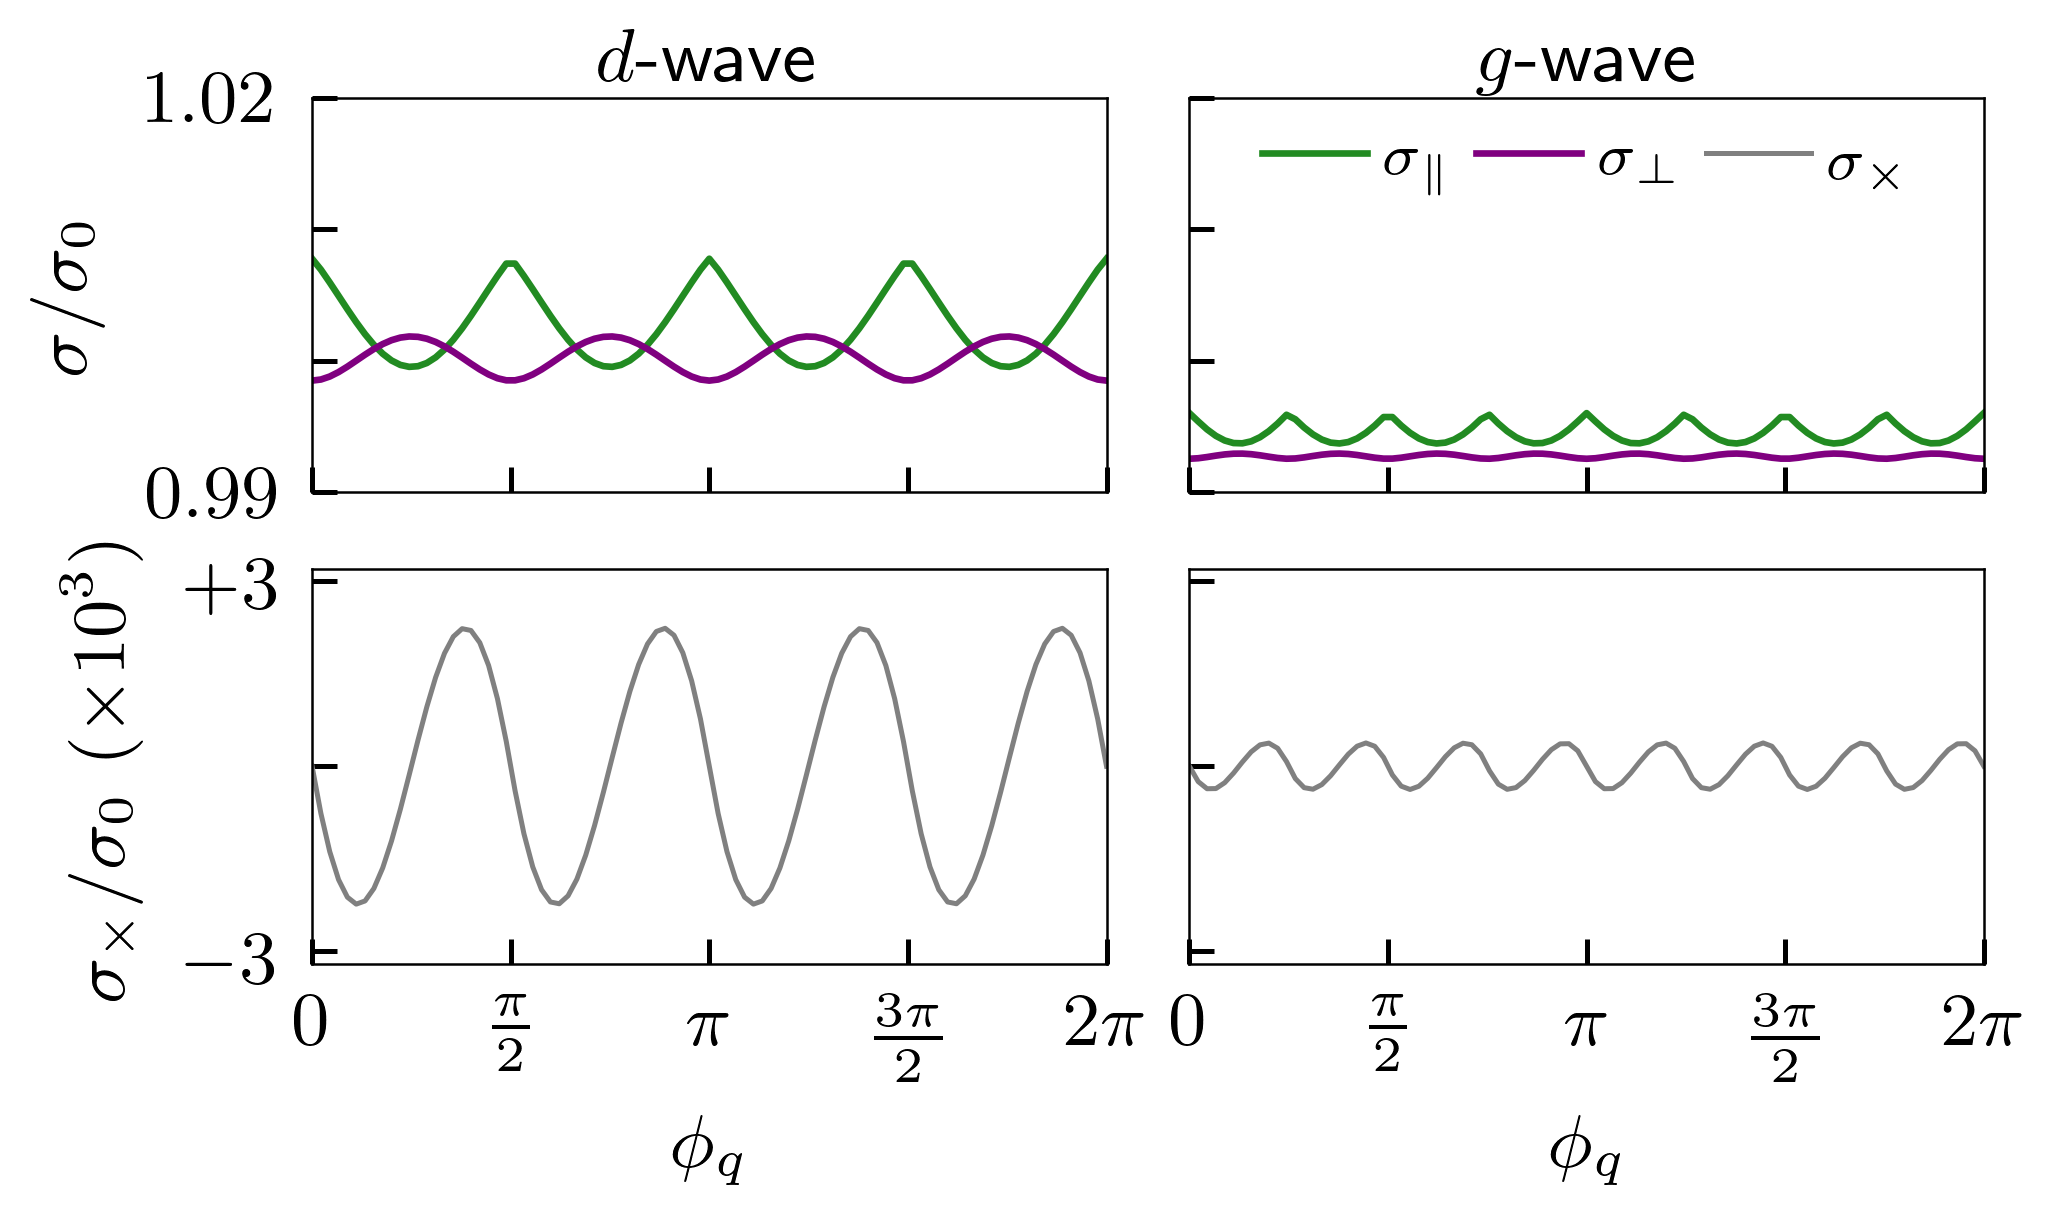

In [ ]:
# -------------------------------------------------------------
# 2×2 Figure (3.4 in × 1.8 in)
# -------------------------------------------------------------
fig, axs = plt.subplots(
    2, 2,
    figsize=(3.4, 2),
    sharex=True,
    sharey="row"
)

plt.subplots_adjust(wspace=0.30, hspace=0.35)

# -------------------------------------------------------------
# Common x-axis settings
# -------------------------------------------------------------
xticks = np.linspace(0, 2*np.pi, 5)
xtick_labels = [
    r"$0$",  r"$\frac{\pi}{2}$",
    r"$\pi$", r"$\frac{3\pi}{2}$",
    r"$2\pi$"
]

# =============================================================
# d-wave — spiral frame
# =============================================================
l_par_d, = axs[0, 0].plot(
    phi_vals,
    sigma_par_d / sigma0_d,
    color="forestgreen",
    lw=0.8,
    marker="",
    label=r"$\sigma_{\parallel}$",
)
l_perp_d, = axs[0, 0].plot(
    phi_vals,
    sigma_perp_d / sigma0_d,
    color="purple",
    lw=0.8,
    marker="",
    label=r"$\sigma_{\perp}$",
)

axs[0, 0].set_ylabel(r"$\sigma / \sigma_0$", labelpad=5)

# =============================================================
# g-wave — spiral frame
# =============================================================
axs[0, 1].plot(
    phi_vals,
    sigma_par_g / sigma0_g,
    color="forestgreen",
    lw=0.8,
    marker="",
)
axs[0, 1].plot(
    phi_vals,
    sigma_perp_g / sigma0_g,
    color="purple",
    lw=0.8,
    marker="",
)

scale = 1e3  # show σ× in units of 10^{-3}

# --- d-wave cross (scaled) ---
l_cross_d, = axs[1, 0].plot(
    phi_vals,
    scale * sigma_cross_d / sigma0_d,   # <- was /sigma0_g in your snippet
    color="gray",
    lw=0.6,
    ls="-",
    label=r"$\sigma_{\times}$",
)

# --- g-wave cross (scaled) ---
axs[1, 1].plot(
    phi_vals,
    scale * sigma_cross_g / sigma0_g,
    color="gray",
    lw=0.6,
    ls="-",
)

axs[1, 0].set_ylabel(r"$10^{3}\,\sigma_{\times}/\sigma_0$", labelpad=5)

# nicer ticks/limits for the scaled axis
for ax in axs[1, :]:
    ax.set_ylim(-3.2, 3.2)
axs[1, 0].set_yticks([-3, 0, 3])

# -------------------------------------------------------------
# Column "suptitles"
# -------------------------------------------------------------
axs[0, 0].set_title(r"$d$-wave", pad=2)
axs[0, 1].set_title(r"$g$-wave", pad=2)

# -------------------------------------------------------------
# Axis formatting
# -------------------------------------------------------------
for ax in axs.flat:
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.tick_params(direction="in", length=3)

for ax in axs[1, :]:
    ax.set_xlabel(r"$\phi_q$")

# -------------------------------------------------------------
# Legend inside the top-left panel
# -------------------------------------------------------------
axs[0, 1].legend(
    handles=[l_par_d, l_perp_d, l_cross_d],
    ncol=3,
    loc="upper center",
    frameon=False,
    fontsize=7,
    handlelength=1.8,
    borderaxespad=0.2,
)

# -------------------------------------------------------------
# Limits / ticks
# -------------------------------------------------------------
axs[0, 0].set_ylim(1.005, 1.02)
axs[0, 1].set_ylim(1.005, 1.02)

axs[1, 0].set_yticks(
    [-3, 0.0, 3],
    labels=[r"$-3$", "", r"$+3$"]
)

axs[1, 0].set_ylabel(r"$\sigma_{\times}/\sigma_0$ $(\times 10^{3})$")

axs[0, 0].set_yticks([0.99, 1.00, 1.01, 1.02], labels=[r"$0.99$", "", "", r"$1.02$"])

fig.tight_layout(pad=0.3)

fig.savefig("Fig3-conductivity_spiral_frame_vs_phiq.svg")
fig.savefig("Fig3-conductivity_spiral_frame_vs_phiq.pdf")


## Optical conductivity

## d-wave

In [ ]:
phiq_list = np.linspace(0.0, np.pi/2, 10)
omega_ax  = np.linspace(0.0, 1.0, 301)[1:]   # exclude 0 to avoid the trivial prefactor omega=0

Nphiq  = len(phiq_list)
Nomega = len(omega_ax)

Pixx = np.zeros((Nphiq, Nomega), dtype=np.complex128)
Piyy = np.zeros((Nphiq, Nomega), dtype=np.complex128)
Pixy = np.zeros((Nphiq, Nomega), dtype=np.complex128)

# You can tune these for speed/accuracy in scan mode
kmax   = params["d-wave"]["kmax"]
Nk     = 1200
Ntheta = 720

T = 0.05

for i, phi_q in tqdm(list(enumerate(phiq_list)), total=Nphiq):
    qx = q * np.cos(phi_q)
    qy = q * np.sin(phi_q)

    # 1) precompute k-dependent kernel ONCE per (qx,qy, T, mu, params...)
    kernel = precompute_Pi_kernel_polar(
        m=params["d-wave"]["m"],
        Kx=params["d-wave"]["Kx"],
        Kz=params["d-wave"]["Kz"],
        symmetry=params["d-wave"]["symmetry"],
        mu=params["d-wave"]["mu"],
        T=T,
        qx=qx, qy=qy,
        kmax=kmax,
        Nk=Nk,
        Ntheta=Ntheta,
        use_pi_symmetry=False,
        rtol_node=1e-14,
        occ_tol=1e-14,
    )

    Pxx, Pyy, Pxy = Pi_tensor_many_omega(
        omegas=omega_ax,
        eta=params["d-wave"]["eta"],
        kernel=kernel
    )

    Pixx[i, :] = Pxx
    Piyy[i, :] = Pyy
    Pixy[i, :] = Pxy


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
sigma_xx = Pixx / (1j * omega_ax)
sigma_yy = Piyy / (1j * omega_ax)
sigma_xy = Pixy / (1j * omega_ax)
sigma_yx = Pixy / (1j * omega_ax)

sigma = np.stack([
    np.stack([sigma_xx, sigma_xy], axis=-1),
    np.stack([sigma_yx, sigma_yy], axis=-1)
], axis=-2)

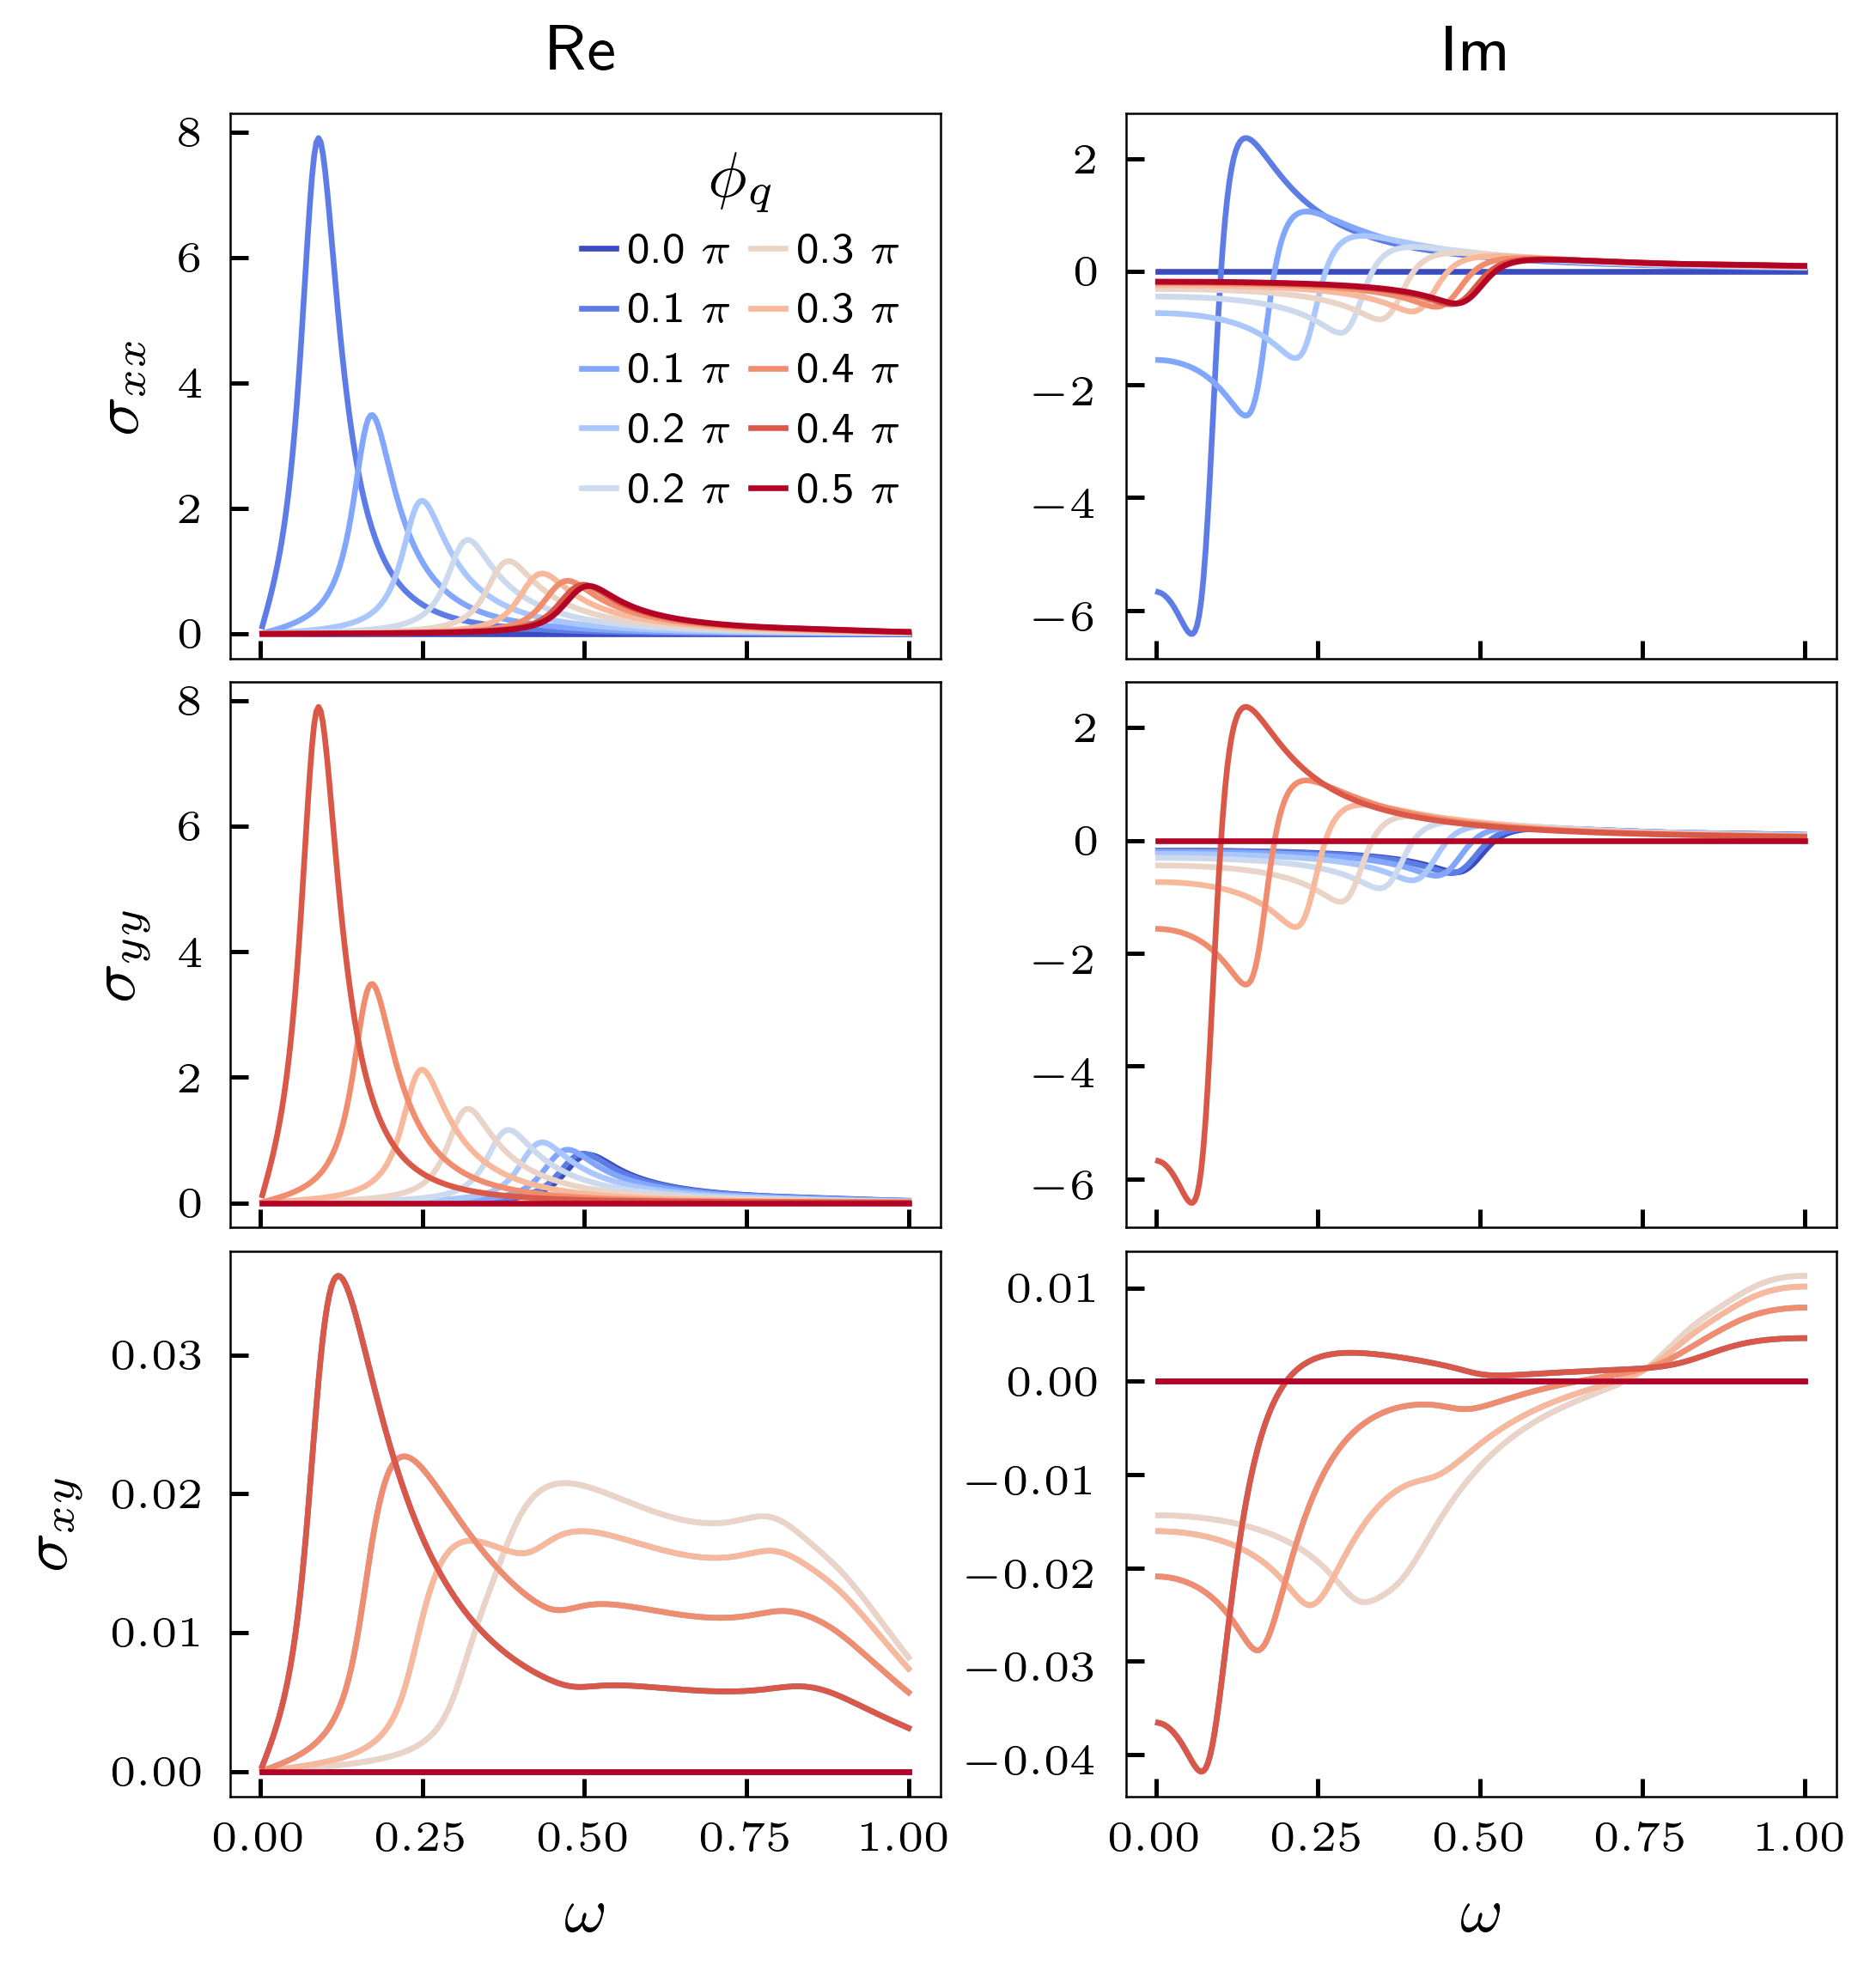

In [ ]:
# ---------------------------------------------------------
# Plotting setup
# ---------------------------------------------------------
cmap = mpl.colormaps["coolwarm"]
Nphi = len(phiq_list)

fig, axes = plt.subplots(3, 2, figsize=(3.6, 3.8), sharex=True)
plt.subplots_adjust(wspace=0.35, hspace=0.30)

# ---------------------------------------------------------
# Loop over φq
# ---------------------------------------------------------
for i, phi_q in enumerate(phiq_list):
    norm = plt.Normalize(vmin=phiq_list[0], vmax=phiq_list[-1])
    col  = cmap(norm(phiq_list[i]))

    label = rf"{phi_q/np.pi:.1f} $\pi$"

    sig_xx = sigma_xx[i]
    sig_yy = sigma_yy[i]
    sig_xy = sigma_xy[i]

    # -----------------------------------------------------
    # σ_xx
    # -----------------------------------------------------
    axes[0,0].plot(omega_ax, sig_xx.real, lw=0.8, color=col, label=label)
    axes[0,1].plot(omega_ax, sig_xx.imag, lw=0.8, color=col)

    # -----------------------------------------------------
    # σ_yy
    # -----------------------------------------------------
    axes[1,0].plot(omega_ax, sig_yy.real, lw=0.8, color=col)
    axes[1,1].plot(omega_ax, sig_yy.imag, lw=0.8, color=col)

    # -----------------------------------------------------
    # σ_xy
    # -----------------------------------------------------
    axes[2,0].plot(omega_ax, sig_xy.real, lw=0.8, color=col)
    axes[2,1].plot(omega_ax, sig_xy.imag, lw=0.8, color=col)

# ---------------------------------------------------------
# Labels and titles
# ---------------------------------------------------------
axes[0,0].set_title("Re")
axes[0,1].set_title("Im")

axes[0,0].set_ylabel(r"$\sigma_{xx}$")
axes[1,0].set_ylabel(r"$\sigma_{yy}$")
axes[2,0].set_ylabel(r"$\sigma_{xy}$")

axes[2,0].set_xlabel(r"$\omega$")
axes[2,1].set_xlabel(r"$\omega$")

# Legend only in top-left panel
axes[0,0].legend(title=r"$\phi_q$", fontsize=6, frameon=False, ncol=2)

# Ticks formatting
for ax in axes.flat:
    ax.tick_params(axis="both", direction="in", labelsize=6)

plt.tight_layout(pad=0.3)
plt.show()

/tmp/ipykernel_251716/1597493564.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("coolwarm")


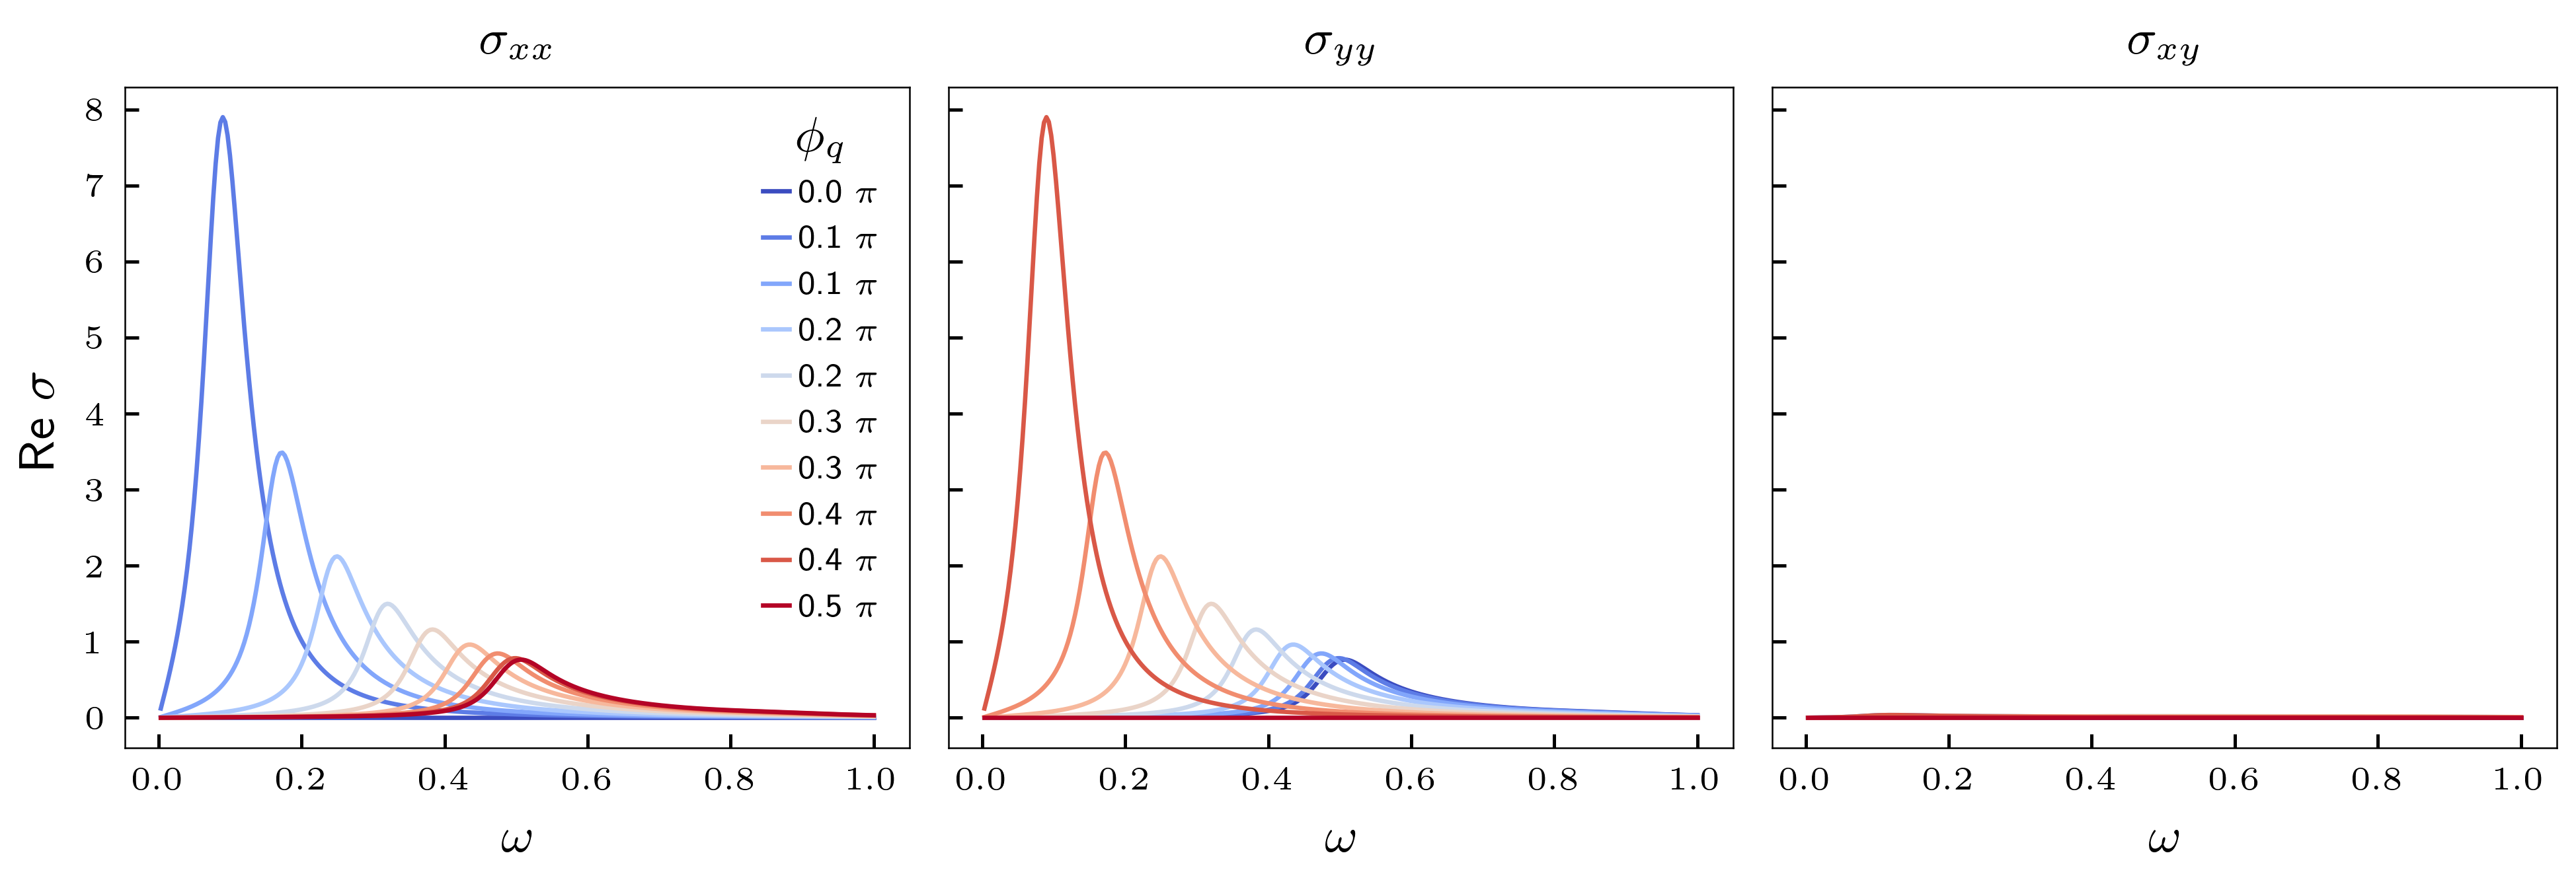

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.35)

cmap = get_cmap("coolwarm")
norm = plt.Normalize(vmin=phiq_list[0], vmax=phiq_list[-1])

for i, phi_q in enumerate(phiq_list):
    col   = cmap(norm(phi_q))
    label = rf"{phi_q/np.pi:.1f} $\pi$"

    sig_xx = sigma_xx[i].real
    sig_yy = sigma_yy[i].real
    sig_xy = sigma_xy[i].real

    axes[0].plot(omega_ax, sig_xx, lw=0.8, color=col, label=label)
    axes[1].plot(omega_ax, sig_yy, lw=0.8, color=col)
    axes[2].plot(omega_ax, sig_xy, lw=0.8, color=col)

# ---------------------------------------------------------
# Labels
# ---------------------------------------------------------
axes[0].set_ylabel(r"Re $\sigma$")
axes[0].set_title(r"$\sigma_{xx}$")
axes[1].set_title(r"$\sigma_{yy}$")
axes[2].set_title(r"$\sigma_{xy}$")

for ax in axes:
    ax.set_xlabel(r"$\omega$")
    ax.tick_params(axis="both", direction="in", labelsize=6)

# Legend only in first panel
axes[0].legend(title=r"$\phi_q$", fontsize=6, frameon=False, ncol=1)

plt.tight_layout(pad=0.3)
plt.show()


In [ ]:
theta_plus, sigma_plus, sigma_minus, A, D = principal_axes_from_M(
    Mxx=sigma_xx.real,
    Myy=sigma_yy.real,
    Mxy=sigma_xy.real,
)

In [ ]:
omega_list = [0.1, 0.3, 0.6, 0.8]

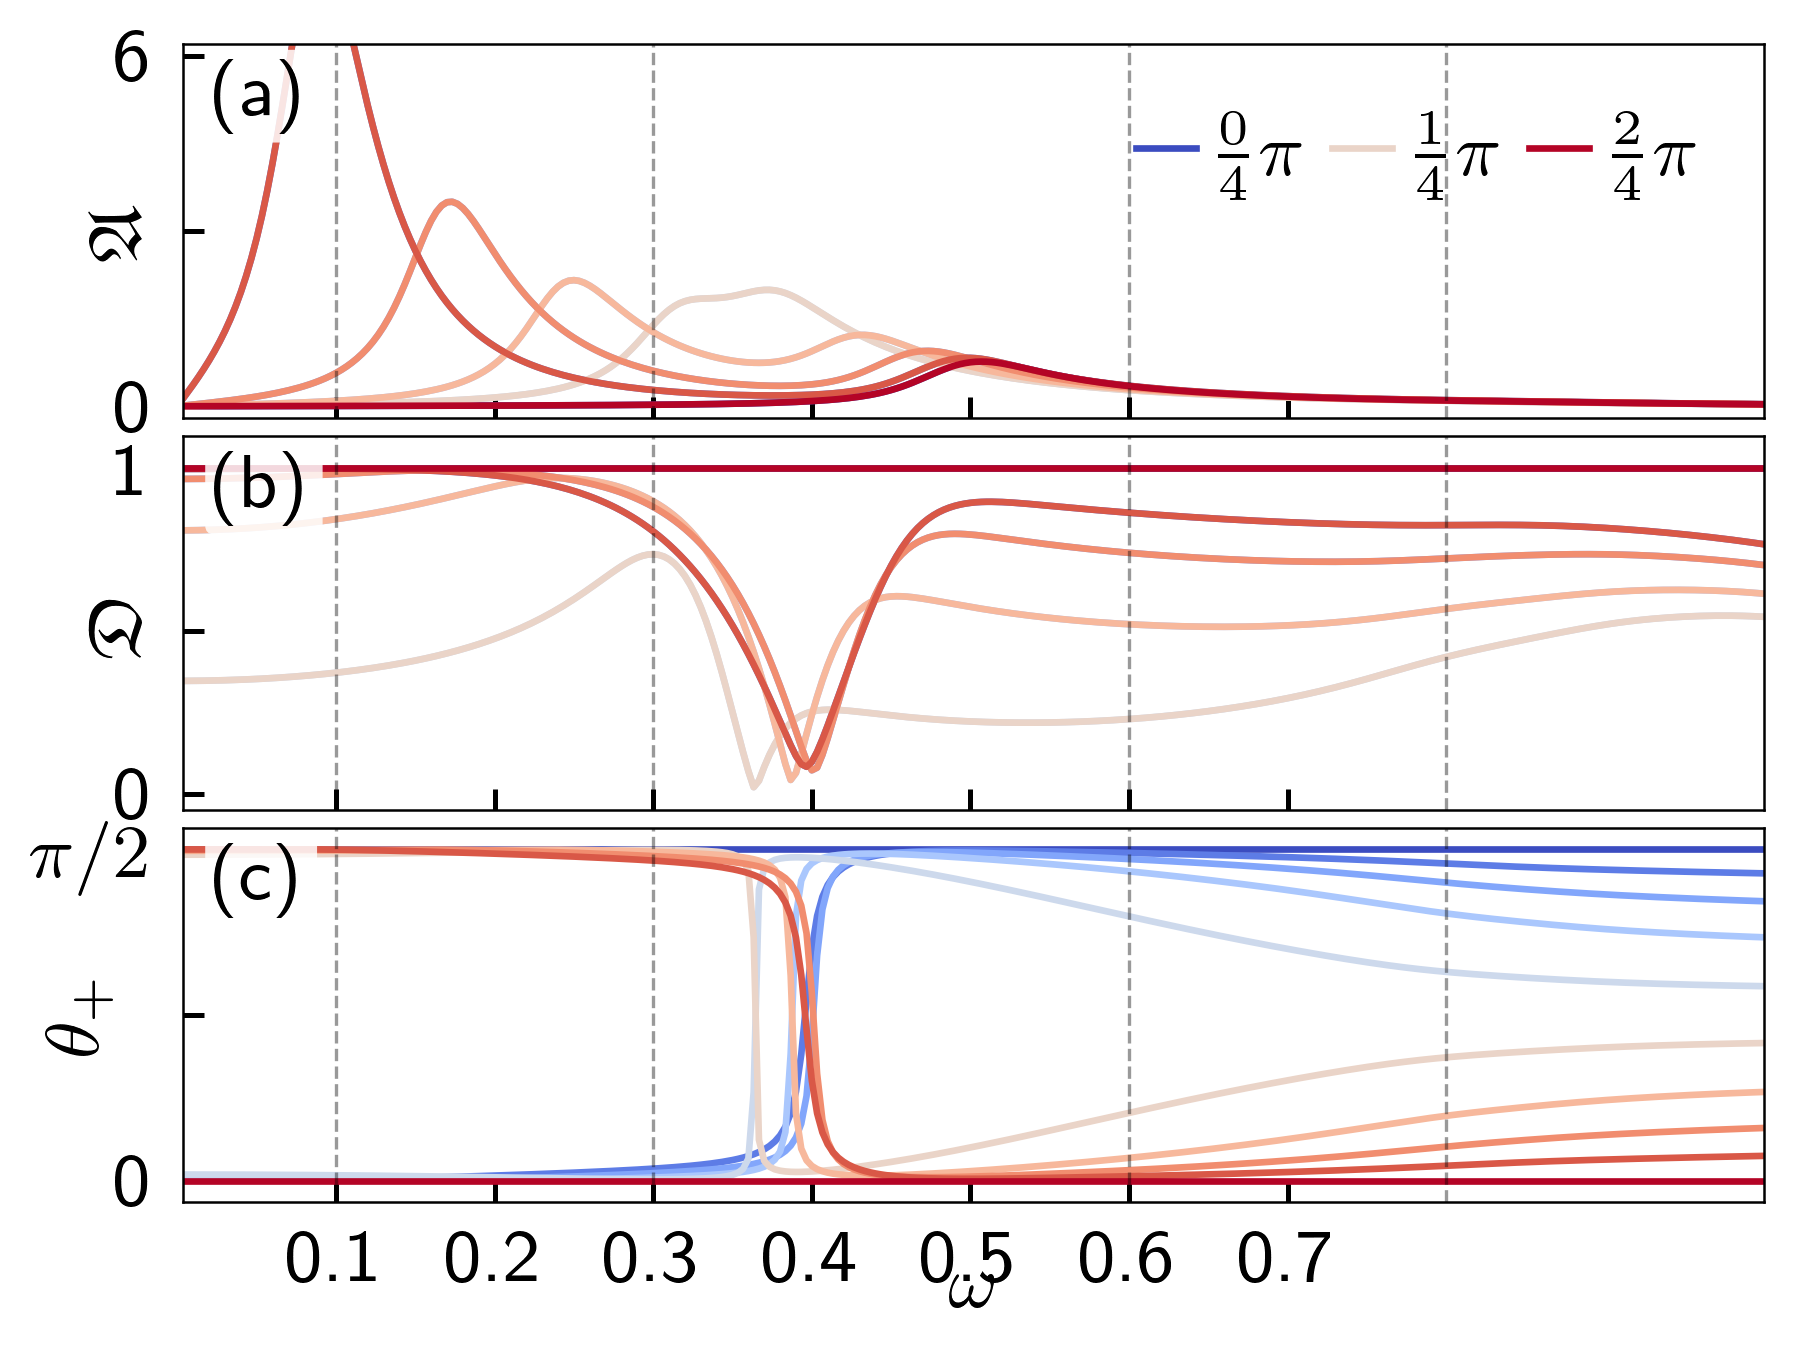

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=phiq_list[0], vmax=phiq_list[-1])

fig = plt.figure(figsize=(3.4, 4.0))
gs  = fig.add_gridspec(
    5, 1,
    height_ratios=[1.0, 1.0, 1.0, 0.15, 1.6],
    hspace=0.05,
)

axA = fig.add_subplot(gs[0])
axD = fig.add_subplot(gs[1], sharex=axA)
axT = fig.add_subplot(gs[2], sharex=axA)

# -------------------------------------------------
# Panel labels (a), (b), (c)
# -------------------------------------------------
panel_kw = dict(
    transform=None,  
    va="top",
    ha="left",
)
axA.text(0.02, 0.96, r"(a)", transform=axA.transAxes, va="top", ha="left", 
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.85))
axD.text(0.02, 0.96, r"(b)", transform=axD.transAxes, va="top", ha="left", 
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.85))
axT.text(0.02, 0.96, r"(c)", transform=axT.transAxes, va="top", ha="left", 
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.85))

# -------------------------------------------------
# ω-dependent observables
# -------------------------------------------------
for i, phi_q in enumerate(phiq_list):

    col = cmap(norm(phi_q))

    if i in [0, Nphi//2, Nphi-1]:
        label = rf"$\frac{{{phi_q/np.pi*4:.0f}}}{4}\pi$"
    else:
        label = None

    sp  = sigma_plus[i]
    sm  = sigma_minus[i]
    thp = theta_plus[i]

    A = sp + sm
    D = (sp - sm) / A
    th = thp

    axA.plot(omega_ax, A, marker="", color=col, label=label)
    axD.plot(omega_ax, D, marker="", color=col)
    axT.plot(omega_ax, th, marker="", color=col)

for ax in (axA, axD, axT):
    for omega0 in omega_list:
        ax.axvline(omega0, color="k", marker="", ls="--", lw=0.4, alpha=0.4)
    ax.tick_params(direction="in")

axA.tick_params(labelbottom=False)
axD.tick_params(labelbottom=False)

axA.set_ylabel(r"$\mathfrak{A}$", labelpad=-5)
axD.set_ylabel(r"$\mathfrak{D}$", labelpad=-5)
axT.set_ylabel(r"$\theta_+$", labelpad=-10)

axA.set_yticks([0, 3, 6], labels=["0", "", "6"])
axD.set_yticks([0, 0.5, 1], labels=["0", "", "1"])
axT.set_yticks([0, np.pi/4, np.pi/2], labels=["0", "", r"$\pi/2$"])

axT.set_xticks(
    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    labels=["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7"]
)
axT.set_xlabel(r"$\omega$", labelpad=-5)
axT.set_xlim(omega_ax.min(), omega_ax.max())

axA.legend(
    ncol=3,
    loc="upper right"
)

axA.set_ylim(-0.2, 6.2)
axD.set_ylim(-0.05, 1.1)
axT.set_ylim(-0.1, np.pi/2 + 0.1)

fig.savefig("Fig4-Dichroism.svg")
fig.savefig("Fig4-Dichroism.pdf", dpi=1000)

In [ ]:
n_phi = 181
phis = np.linspace(0.0, np.pi, n_phi)

Nk = 1200
Ntheta = 720

thetas = {om: np.zeros_like(phis, dtype=float) for om in omega_list}
anisos = {om: np.zeros_like(phis, dtype=float) for om in omega_list}

for i, phi_q in tqdm(enumerate(phis), total=len(phis)):
    qx, qy = q * np.cos(phi_q), q * np.sin(phi_q)

    kernel = precompute_Pi_kernel_polar(
        m=params["d-wave"]["m"],
        Kx=params["d-wave"]["Kx"],
        Kz=params["d-wave"]["Kz"],
        symmetry=params["d-wave"]["symmetry"],
        mu=params["d-wave"]["mu"],
        T=T,
        qx=qx, qy=qy,
        kmax=kmax,
        Nk=Nk,
        Ntheta=Ntheta,
        use_pi_symmetry=False,   # set True only if you are sure the integrand has π symmetry
        rtol_node=1e-14,
        occ_tol=1e-14,
    )

    # evaluate for each omega using same kernel (fast)
    for omega0 in omega_list:
        Pxx, Pyy, Pxy = Pi_tensor_many_omega(omegas=np.array([omega0], dtype=float), eta=params["d-wave"]["eta"], kernel=kernel)

        Pixx = complex(Pxx[0])
        Piyy = complex(Pyy[0])
        Pixy = complex(Pxy[0])

        # your convention
        sig_xx = Pixx / (1j * omega0)
        sig_yy = Piyy / (1j * omega0)
        sig_xy = Pixy / (1j * omega0)

        th, sigma_plus, sigma_minus, A, D = principal_axes_from_M(sig_xx.real, sig_yy.real, sig_xy.real, unwrap_axis=None)
        thetas[omega0][i] = float(th) if np.ndim(th) == 0 else th

# unwrap each curve (period π) to avoid jumps
thetas_unw = {om: np.unwrap(arr, period=np.pi) for om, arr in thetas.items()}

theta_ana = np.pi / 2 - phis

  0%|          | 0/181 [00:00<?, ?it/s]

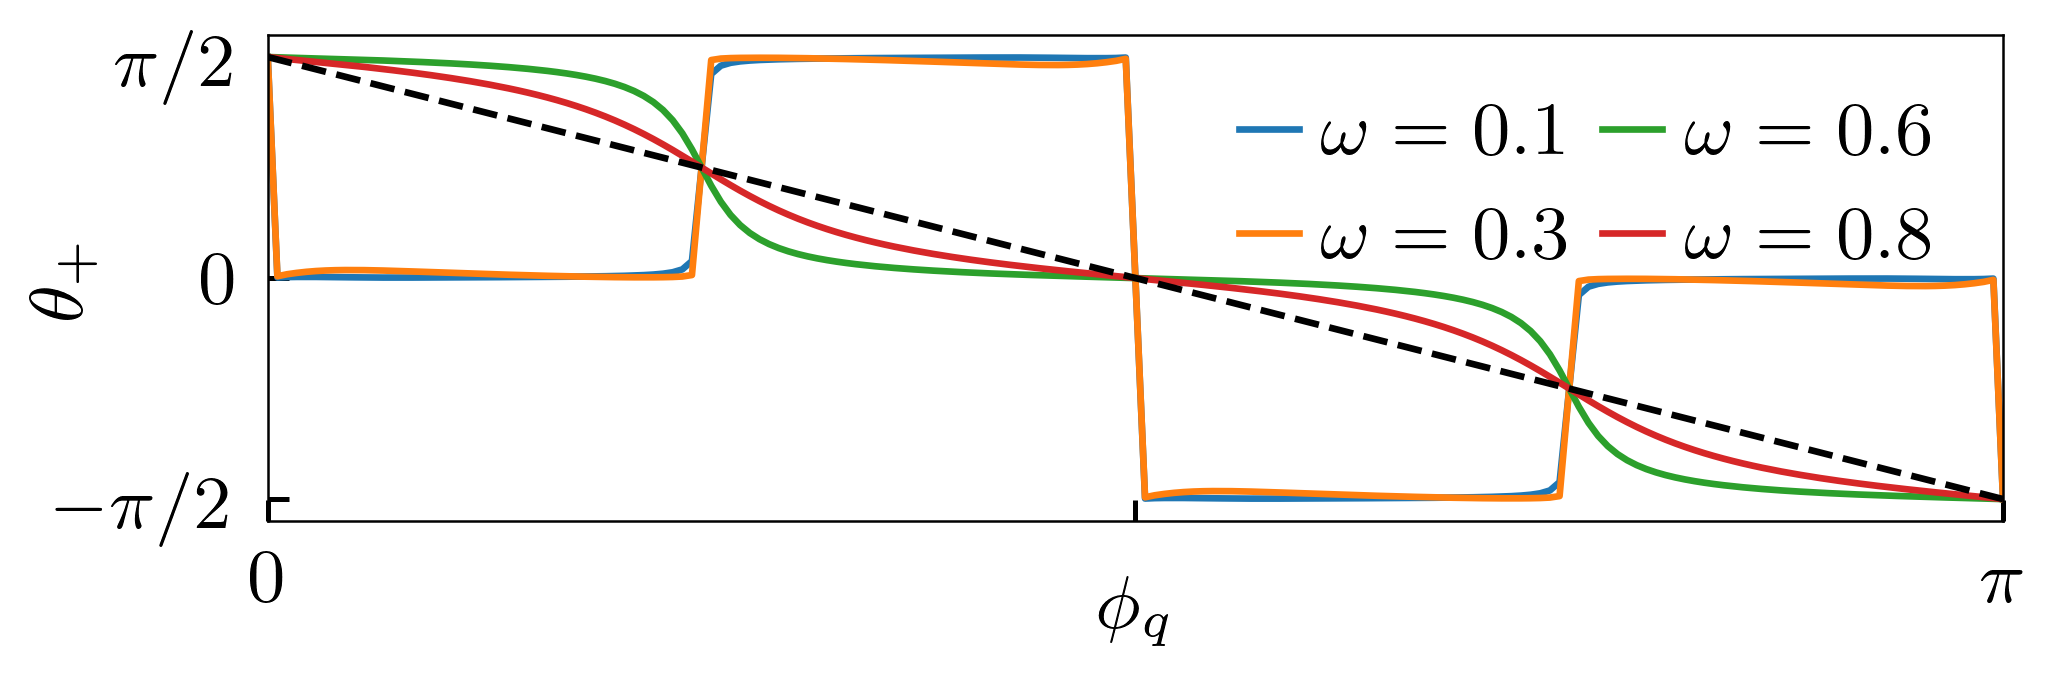

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 1.1))

for omega0 in omega_list:
    ax.plot(phis, thetas_unw[omega0], marker="",  label=rf"$\omega={omega0}$")

ax.plot(phis, theta_ana,  marker="", ls="--", color="k")#, label=r"$\frac{\pi}{2}-\phi_q$")

ax.set_xlim(0, np.pi)
ax.set_xticks([0, np.pi/2, np.pi], labels=[r"$0$", r"", r"$\pi$"])
ax.set_xlabel(r"$\phi_q$", labelpad=-5)

ax.set_ylabel(r"$\theta_+$", labelpad=-5)
ax.set_yticks([-np.pi/2, 0, np.pi / 2], labels=[r"$-\pi/2$", r"$0$", r"$\pi/2$"])
ax.legend(ncols=2)

# ax.set_ylim(-2, 6)

fig.tight_layout(pad=0.3)
fig.savefig("Fig5a-theta_plus_vs_phiq.svg")
fig.savefig("Fig5a-theta_plus_vs_phiq.pdf", dpi=1000)

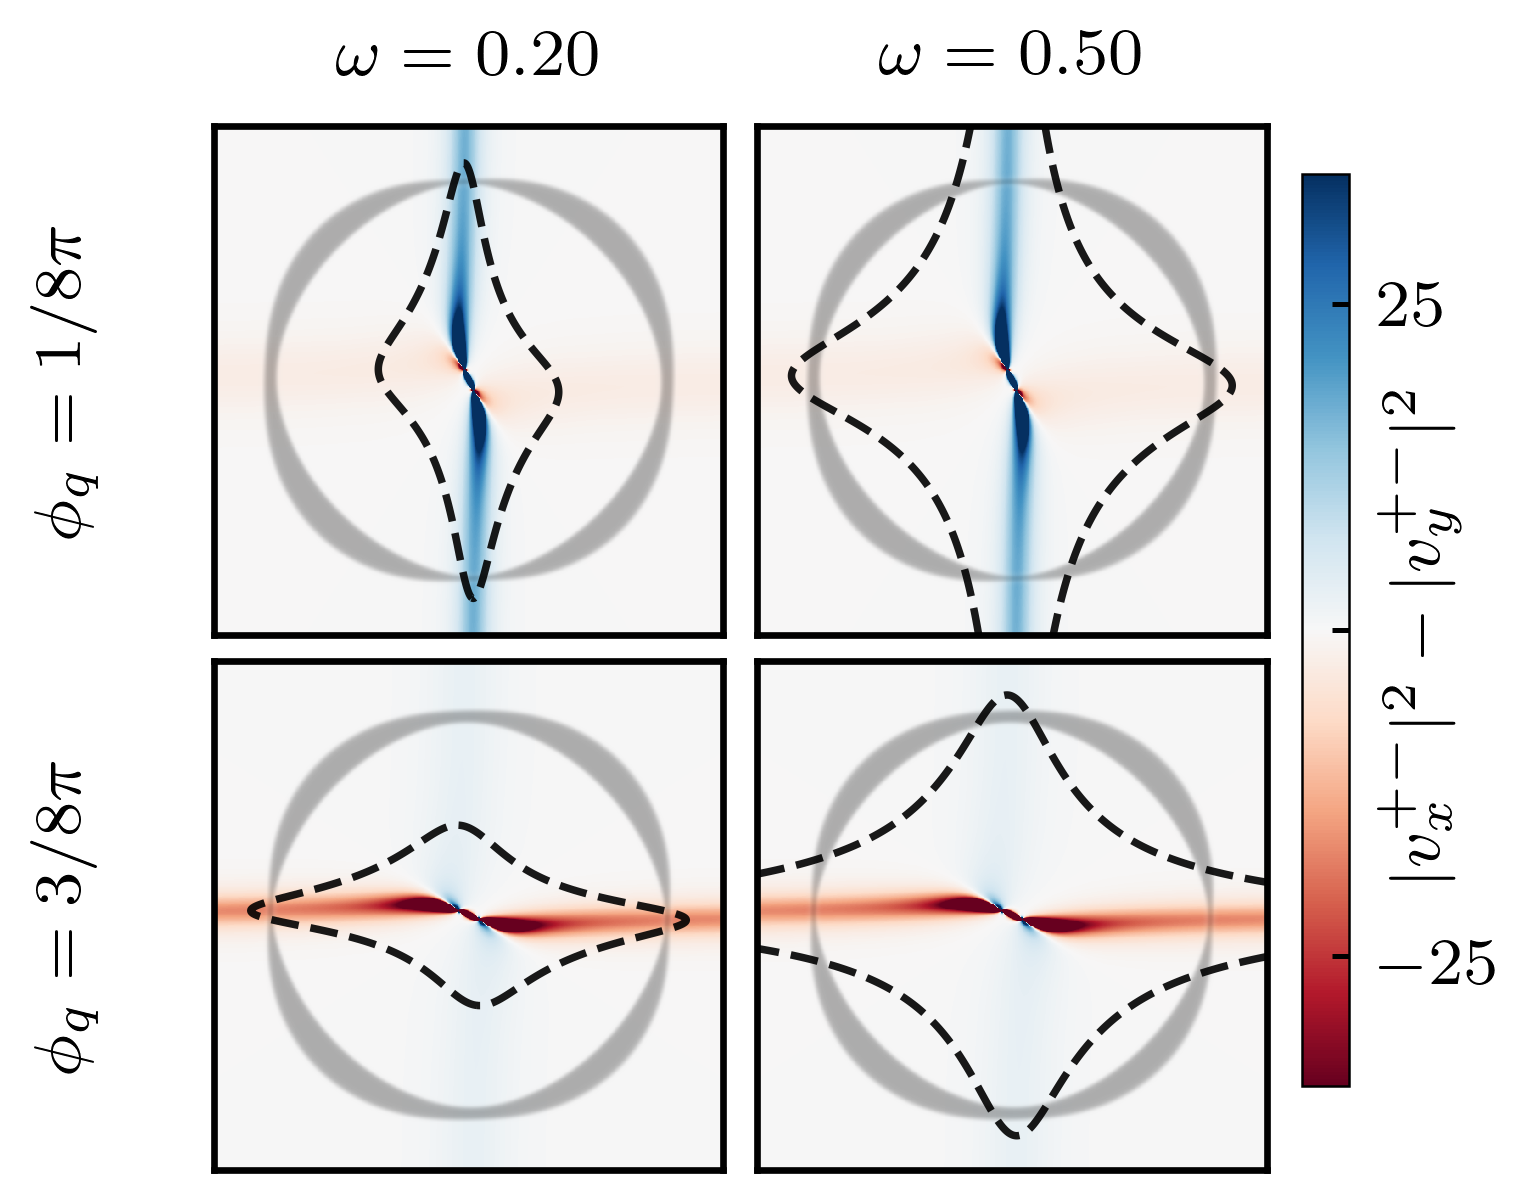

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_kubo_2x2_prb_onecol_simplified_with_pauli(
    *,
    q, omegas, phis=(np.pi/8, 3*np.pi/8),
    m=1.0, Kx=0.5, Kz=1.0, symmetry="d-wave",
    mu=0.0, T=0.01,
    kmax=np.pi, Nk=1001, eta_omega=0.02,
    use_helix_frame=False,
    aniso_mode="v",          # "v" or "kernel"
    resonance="contour",     # "contour" or "overlay" or "none"
    # resonance styling
    alpha_wk=0.35, wk_pow=0.8,
    lw_res=0.9,
    # Pauli overlay
    show_pauli=True,
    pauli_mode="mask",       # "mask" or "contour"
    occ_cut=0.05,
    pauli_floor=5e-3,
    alpha_pauli=0.35, pauli_pow=0.9,
    aniso_quantile=0.995,
    fontsize=8,
):
    mpl.rcParams.update({
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    })

    def compute_panel(phi_q, omega0):
        qx = q*np.cos(phi_q); qy = q*np.sin(phi_q)
        k = np.linspace(-kmax, kmax, Nk)
        KX, KY = np.meshgrid(k, k, indexing="xy")

        d1, d3, d1x, d1y, d3x, d3y = d_fields_np(
            KX, KY, Kx=Kx, Kz=Kz, qx=qx, qy=qy, symmetry=symmetry
        )
        R = np.sqrt(d1*d1 + d3*d3)
        gap = 2.0 * R

        vx = v_interband_np("x", d1, d3, d1x, d1y, d3x, d3y, R)
        vy = v_interband_np("y", d1, d3, d1x, d1y, d3x, d3y, R)

        if use_helix_frame:
            c, s = np.cos(phi_q), np.sin(phi_q)
            vA =  c*vx + s*vy
            vB = -s*vx + c*vy
            aniso_label = r"$|v_{\parallel}^{+-}|^2-|v_{\perp}^{+-}|^2$"
        else:
            vA, vB = vx, vy
            aniso_label = r"$|v_x^{+-}|^2-|v_y^{+-}|^2$"

        eps0 = (KX*KX + KY*KY + 0.25*(qx*qx + qy*qy)) / (2.0*m)
        E_minus = eps0 - R
        E_plus  = eps0 + R
        occ = _fermi_vec(E_minus, mu, T) - _fermi_vec(E_plus, mu, T)
        occ_abs = np.abs(occ)

        Wk = _kubo_weight_map(omega0=omega0, eta_omega=eta_omega, R=R)

        if aniso_mode == "v":
            A = (vA*vA) - (vB*vB)
        elif aniso_mode == "kernel":
            A = occ * ((vA*vA) - (vB*vB)) * Wk
        else:
            raise ValueError("aniso_mode must be 'v' or 'kernel'")

        return A, Wk, occ_abs, gap, aniso_label

    # order panels as (rows=phis, cols=omegas)
    panels = []
    for phi_q in phis:
        for omega0 in omegas:
            A, Wk, occ_abs, gap, label = compute_panel(phi_q, omega0)
            panels.append((phi_q, omega0, A, Wk, occ_abs, gap, label))

    all_abs = np.concatenate([np.abs(p[2]).ravel() for p in panels])
    halfr = float(np.nanquantile(all_abs, aniso_quantile))
    if not np.isfinite(halfr) or halfr <= 0:
        halfr = 1.0

    fig, axes = plt.subplots(
        len(phis), len(omegas),
        figsize=(2.6, 2.0),
        constrained_layout=False,
        sharex=True, sharey=True,
    )

    # ensure 2D array of axes
    axes = np.atleast_2d(axes)

    def draw(ax, *, phi_q, omega0, A, Wk, occ_abs, gap, label):
        im = ax.imshow(
            A, origin="lower",
            extent=[-kmax, kmax, -kmax, kmax],
            aspect="equal",
            cmap="RdBu",
            norm=mpl.colors.CenteredNorm(0.0, halfr),
            interpolation="nearest",
            zorder=-3,
        )

        # Resonance cue
        if resonance == "overlay":
            W1 = Wk / (np.max(Wk) + 1e-30)
            ax.imshow(
                W1, origin="lower",
                extent=[-kmax, kmax, -kmax, kmax],
                aspect="equal",
                cmap="Greys",
                alpha=alpha_wk * (W1**wk_pow),
                interpolation="nearest",
                zorder=-2,
            )
        elif resonance == "contour":
            Ny, Nx = gap.shape
            xs = np.linspace(-kmax, kmax, Nx)
            ys = np.linspace(-kmax, kmax, Ny)
            X, Y = np.meshgrid(xs, ys, indexing="xy")
            ax.contour(
                X, Y, gap,
                levels=[omega0],
                colors="k",
                linewidths=lw_res,
                linestyles="--",
                alpha=0.9,
                zorder=5,
            )
        elif resonance == "none":
            pass
        else:
            raise ValueError("resonance must be 'contour', 'overlay', or 'none'")

        # Pauli overlay
        if show_pauli:
            if pauli_mode == "mask":
                P = occ_abs / (np.max(occ_abs) + 1e-30)
                Pm = np.where(P > pauli_floor, P, np.nan)
                ax.imshow(
                    Pm, origin="lower",
                    extent=[-kmax, kmax, -kmax, kmax],
                    aspect="equal",
                    cmap="Greys",
                    alpha=alpha_pauli * (np.nan_to_num(Pm, nan=0.0)**pauli_pow),
                    interpolation="nearest",
                    zorder=-1,
                )
            elif pauli_mode == "contour":
                Ny, Nx = occ_abs.shape
                xs = np.linspace(-kmax, kmax, Nx)
                ys = np.linspace(-kmax, kmax, Ny)
                X, Y = np.meshgrid(xs, ys, indexing="xy")
                ax.contour(
                    X, Y, occ_abs,
                    levels=[occ_cut],
                    colors="k",
                    linewidths=0.8,
                    linestyles="-",
                    alpha=0.8,
                    zorder=6,
                )
            else:
                raise ValueError("pauli_mode must be 'mask' or 'contour'")

        ax.set_xticks([])
        ax.set_yticks([])
        for sp in ax.spines.values():
            sp.set_linewidth(0.8)

        return im, label

    im0, label0 = None, None
    for r, phi_q in enumerate(phis):
        for c, omega0 in enumerate(omegas):
            phi_q_, omega0_, A, Wk, occ_abs, gap, label = panels[r*len(omegas) + c]
            im, lab = draw(
                axes[r, c],
                phi_q=phi_q_, omega0=omega0_,
                A=A, Wk=Wk, occ_abs=occ_abs, gap=gap, label=label
            )
            if im0 is None:
                im0, label0 = im, lab

            # Column titles (omega on top)
            if r == 0:
                axes[r, c].set_title(rf"$\omega={omega0:.2f}$")

            # Row labels (phi_q on the left)
            if c == 0:
                axes[r, c].set_ylabel(rf"$\phi_q={int(phi_q/np.pi*8):d}/8\pi$",
                                      rotation=90, labelpad=18, va="center")

    # Adjust layout to make room for row labels + right colorbar
    fig.subplots_adjust(left=0.18, right=0.86, bottom=0.05, top=0.92,
                        wspace=0.05, hspace=0.05)

    # Colorbar on the right, spanning the grid height
    cax = fig.add_axes([0.88, 0.12, 0.03, 0.76])
    cbar = fig.colorbar(im0, cax=cax, orientation="vertical")
    cbar.ax.tick_params(direction="in", length=2)
    cbar.ax.set_yticks([-25, 0, 25], labels=[r"$-25$", r"", r"$25$"])

    # choose your ticks; keep symmetric
    cbar.set_ticks([-25, 0, 25])
    cbar.set_ticklabels([r"$-25$", r"", r"$25$"])
    cbar.set_label(label0, rotation=90, labelpad=-15)

    return fig, axes


# Example call:
fig, axes = plot_kubo_2x2_prb_onecol_simplified_with_pauli(
    q=q,
    omegas=(0.2, 0.5),
    phis=(np.pi/8, 3*np.pi/8),
    m=params["d-wave"]["m"],
    Kx=params["d-wave"]["Kx"],
    Kz=params["d-wave"]["Kz"],
    symmetry=params["d-wave"]["symmetry"],
    mu=params["d-wave"]["mu"],
    T=0.05,
    kmax=np.pi,
    Nk=601,
    eta_omega=params["d-wave"]["eta"],
    resonance="contour",
    show_pauli=True,
    pauli_mode="mask",
    alpha_pauli=0.30,
)
plt.show()
fig.savefig("Fig5b-kubo_anisotropy_with_pauli_dwave.svg")
fig.savefig("Fig5b-kubo_anisotropy_with_pauli_dwave.pdf", dpi=1000)

## g-wave

In [ ]:
phiq_list = np.linspace(0.0, np.pi/2, 8)
omega_ax  = np.linspace(0.0, 1.0, 301)[1:]   # exclude 0 to avoid the trivial prefactor omega=0

Nphiq  = len(phiq_list)
Nomega = len(omega_ax)

Pixx = np.zeros((Nphiq, Nomega), dtype=np.complex128)
Piyy = np.zeros((Nphiq, Nomega), dtype=np.complex128)
Pixy = np.zeros((Nphiq, Nomega), dtype=np.complex128)

# You can tune these for speed/accuracy in scan mode
kmax   = params["g-wave"]["kmax"]
Nk     = 1200
Ntheta = 720

T = 0.05

for i, phi_q in tqdm(list(enumerate(phiq_list)), total=Nphiq):
    qx = q * np.cos(phi_q)
    qy = q * np.sin(phi_q)

    # 1) precompute k-dependent kernel ONCE per (qx,qy, T, mu, params...)
    kernel = precompute_Pi_kernel_polar(
        m=params["g-wave"]["m"],
        Kx=params["g-wave"]["Kx"],
        Kz=params["g-wave"]["Kz"],
        symmetry=params["g-wave"]["symmetry"],
        mu=params["g-wave"]["mu"],
        T=T,
        qx=qx, qy=qy,
        kmax=params["g-wave"]["kmax"],
        Nk=Nk,
        Ntheta=Ntheta,
        use_pi_symmetry=False,    # ~2× speedup if symmetry holds (usually yes here)
        rtol_node=1e-14,
        occ_tol=1e-14,
    )

    # 2) evaluate Π_xx, Π_yy, Π_xy for ALL ω in one shot
    Pxx, Pyy, Pxy = Pi_tensor_many_omega(
        omegas=omega_ax,
        eta=params["g-wave"]["eta"],
        kernel=kernel
    )

    Pixx[i, :] = Pxx
    Piyy[i, :] = Pyy
    Pixy[i, :] = Pxy

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
sigma_xx = Pixx / (1j * omega_ax)
sigma_yy = Piyy / (1j * omega_ax)
sigma_xy = Pixy / (1j * omega_ax)
sigma_yx = Pixy / (1j * omega_ax)

sigma = np.stack([
    np.stack([sigma_xx, sigma_xy], axis=-1),
    np.stack([sigma_yx, sigma_yy], axis=-1)
], axis=-2)

/tmp/ipykernel_18238/1597493564.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("coolwarm")


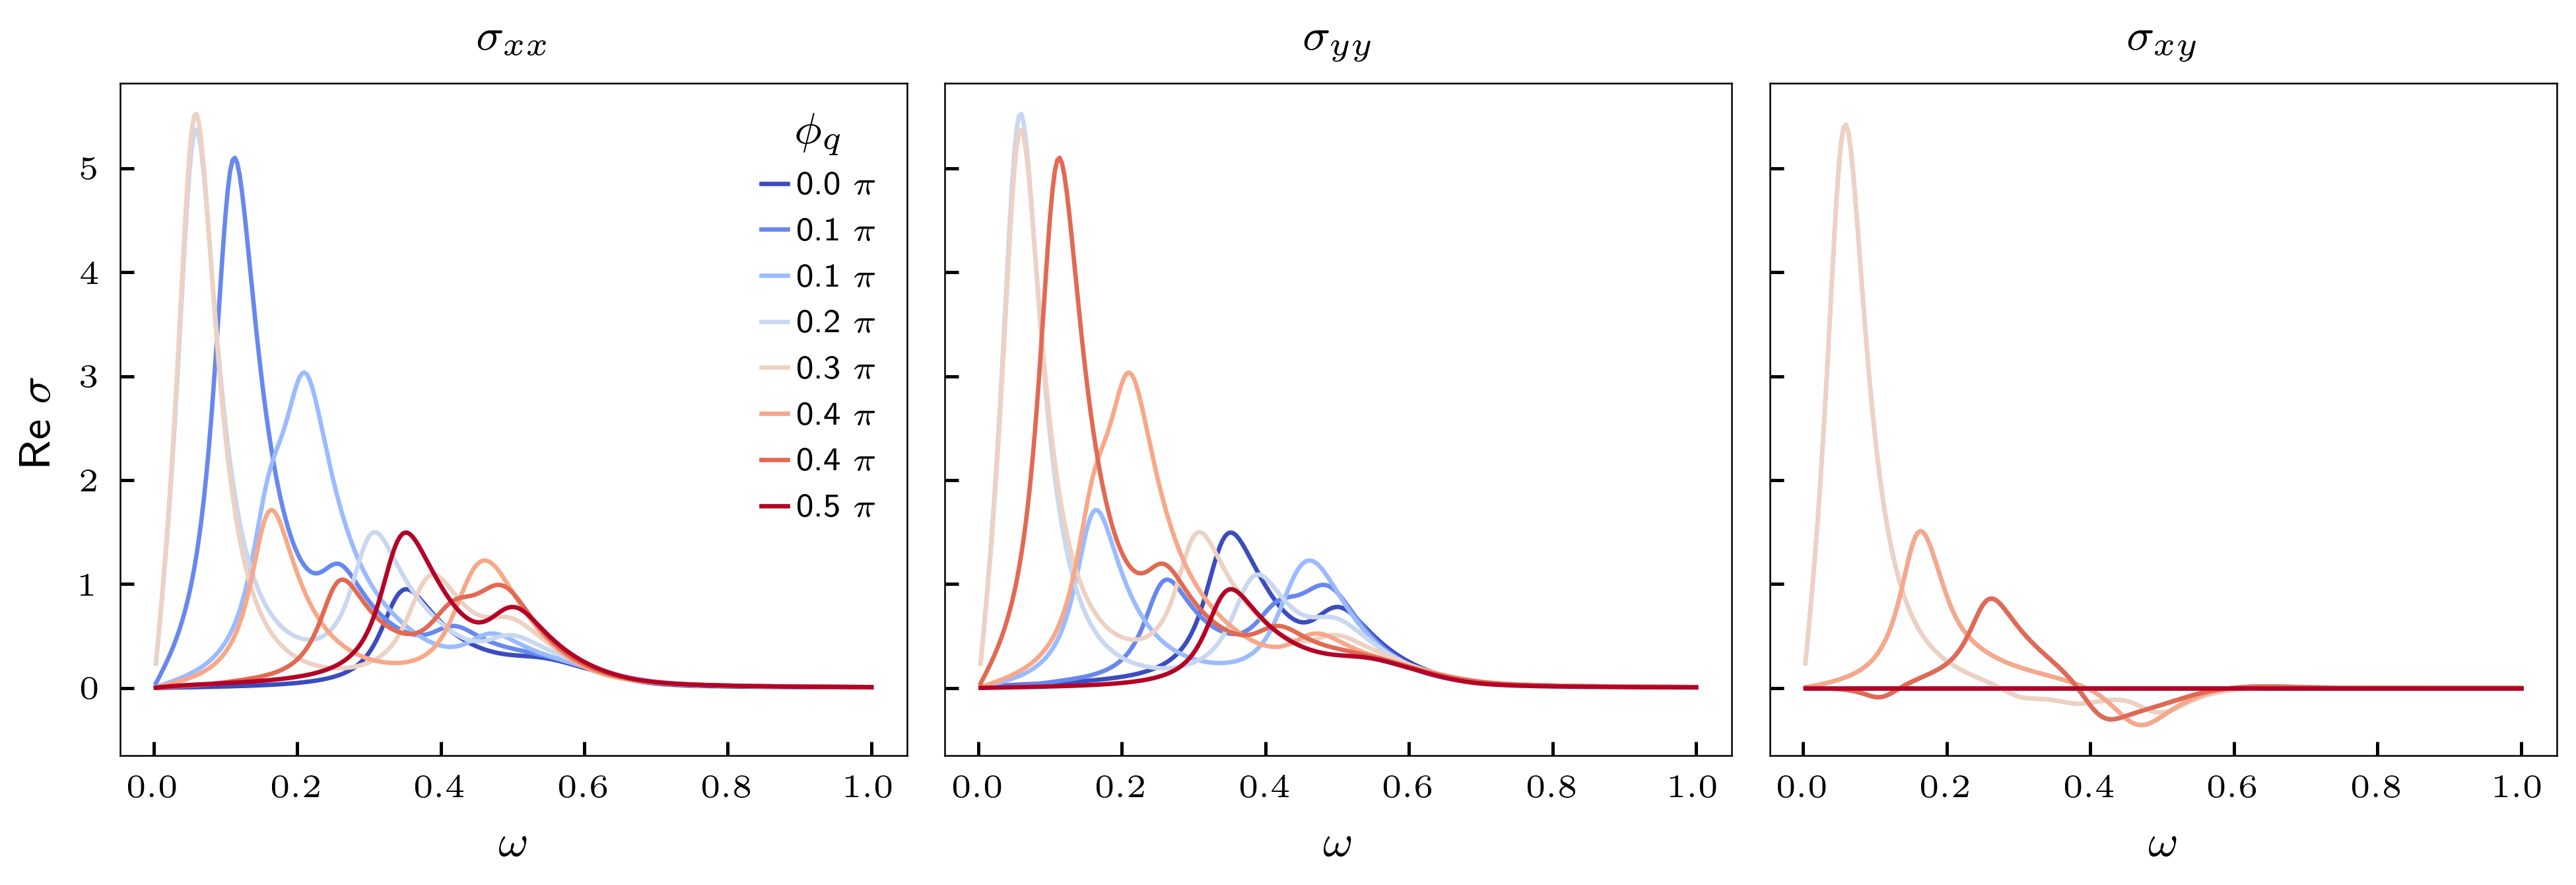

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.35)

cmap = get_cmap("coolwarm")
norm = plt.Normalize(vmin=phiq_list[0], vmax=phiq_list[-1])

for i, phi_q in enumerate(phiq_list):
    col   = cmap(norm(phi_q))
    label = rf"{phi_q/np.pi:.1f} $\pi$"

    sig_xx = sigma_xx[i].real
    sig_yy = sigma_yy[i].real
    sig_xy = sigma_xy[i].real

    axes[0].plot(omega_ax, sig_xx, lw=0.8, color=col, label=label)
    axes[1].plot(omega_ax, sig_yy, lw=0.8, color=col)
    axes[2].plot(omega_ax, sig_xy, lw=0.8, color=col)

# ---------------------------------------------------------
# Labels
# ---------------------------------------------------------
axes[0].set_ylabel(r"Re $\sigma$")
axes[0].set_title(r"$\sigma_{xx}$")
axes[1].set_title(r"$\sigma_{yy}$")
axes[2].set_title(r"$\sigma_{xy}$")

for ax in axes:
    ax.set_xlabel(r"$\omega$")
    ax.tick_params(axis="both", direction="in", labelsize=6)

# Legend only in first panel
axes[0].legend(title=r"$\phi_q$", fontsize=6, frameon=False, ncol=1)

plt.tight_layout(pad=0.3)
plt.show()


In [ ]:
theta_plus, sigma_plus, sigma_minus, A, D = principal_axes_from_M(
    Mxx=sigma_xx.real,
    Myy=sigma_yy.real,
    Mxy=sigma_xy.real
)

theta_plus = np.unwrap(theta_plus, axis=1, period=np.pi)

In [ ]:
omega_list = [0.1, 0.35, 0.5, 0.6]

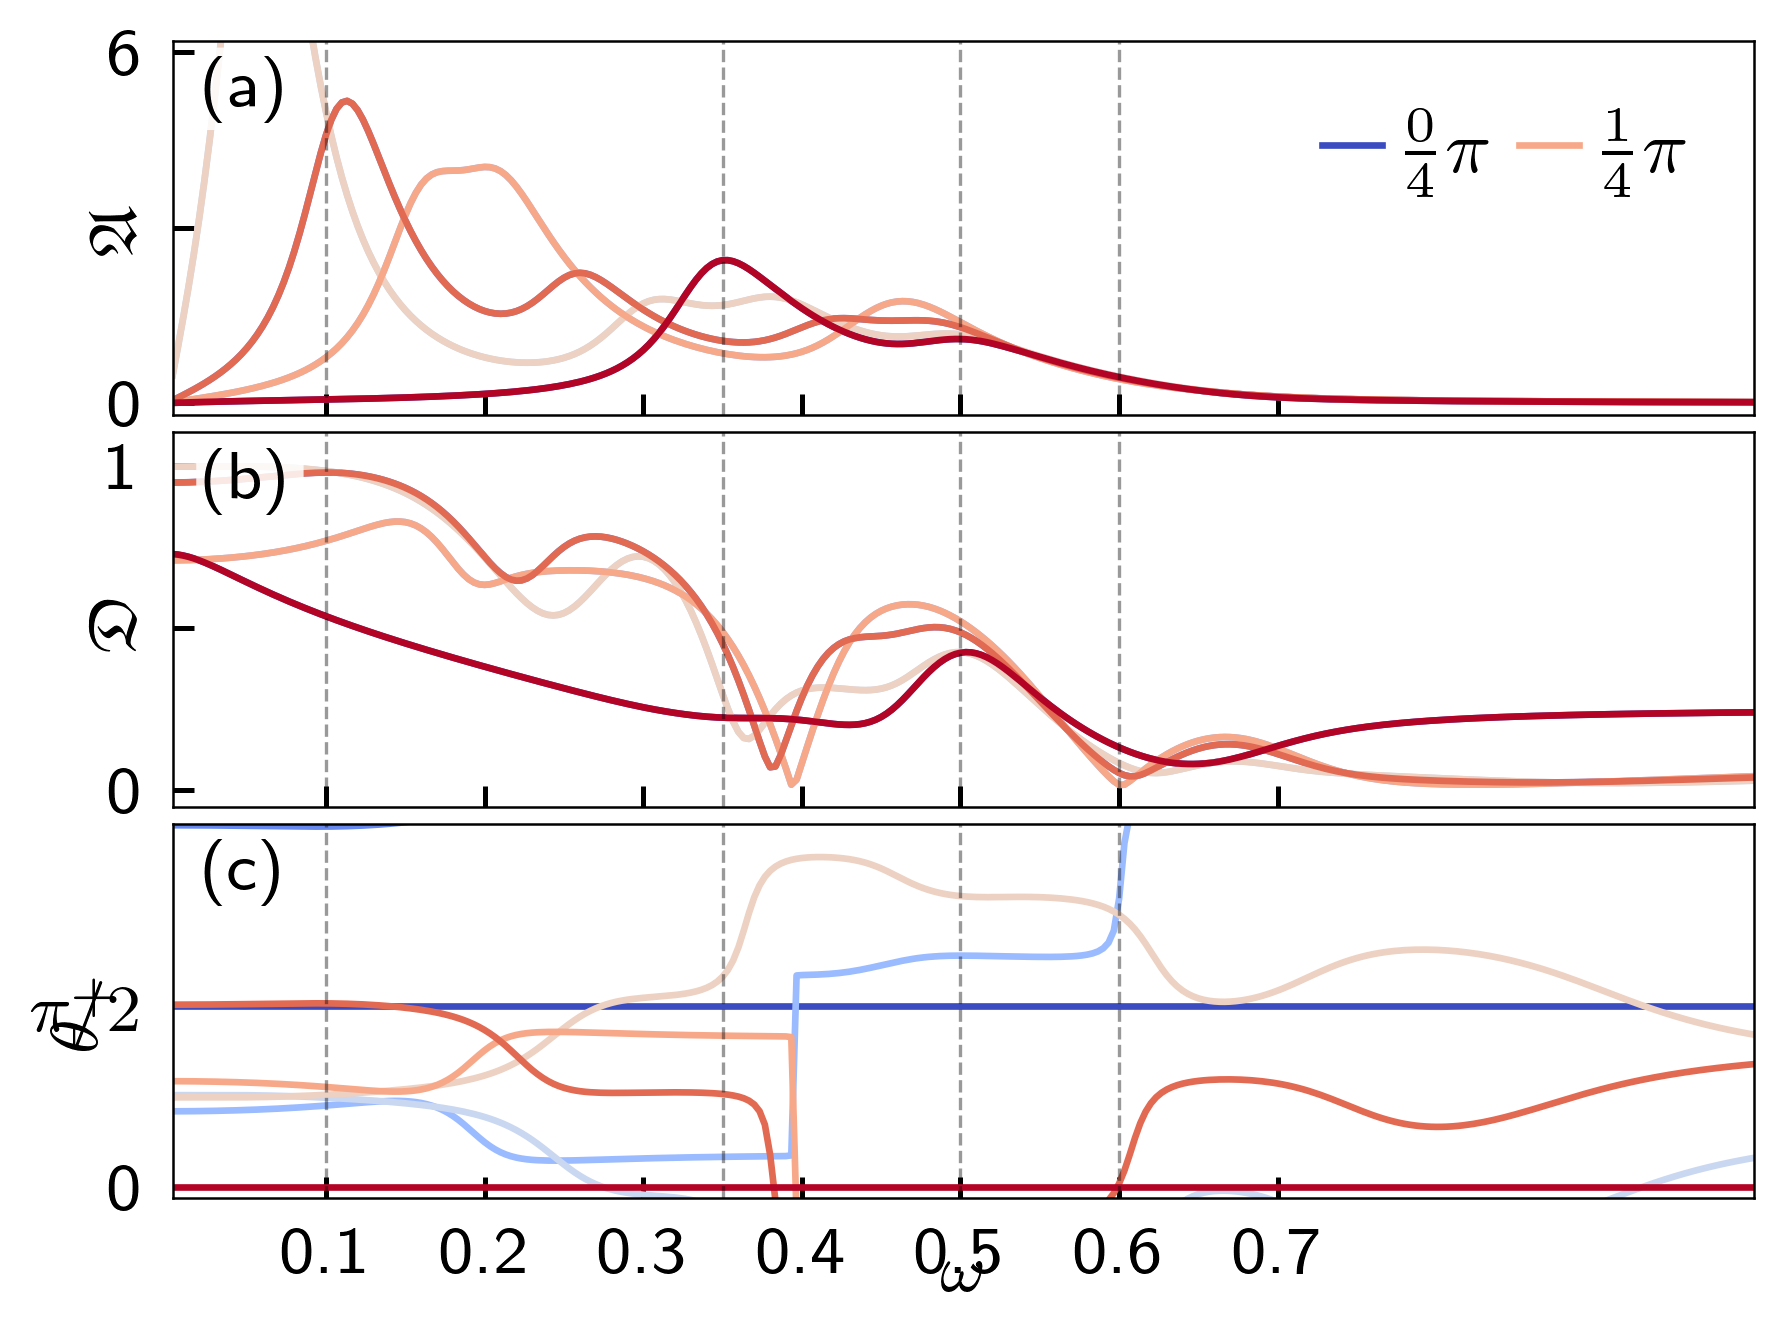

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=phiq_list[0], vmax=phiq_list[-1])

fig = plt.figure(figsize=(3.4, 4.0))
gs  = fig.add_gridspec(
    5, 1,
    height_ratios=[1.0, 1.0, 1.0, 0.15, 1.6],
    hspace=0.05,
)

axA = fig.add_subplot(gs[0])
axD = fig.add_subplot(gs[1], sharex=axA)
axT = fig.add_subplot(gs[2], sharex=axA)

# -------------------------------------------------
# Panel labels (a), (b), (c)
# -------------------------------------------------
panel_kw = dict(
    transform=None,  
    va="top",
    ha="left",
)
axA.text(0.02, 0.96, r"(a)", transform=axA.transAxes, va="top", ha="left", 
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.85))
axD.text(0.02, 0.96, r"(b)", transform=axD.transAxes, va="top", ha="left", 
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.85))
axT.text(0.02, 0.96, r"(c)", transform=axT.transAxes, va="top", ha="left", 
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.85))

# -------------------------------------------------
# ω-dependent observables
# -------------------------------------------------
for i, phi_q in enumerate(phiq_list):

    col = cmap(norm(phi_q))

    if i in [0, Nphi//2, Nphi-1]:
        label = rf"$\frac{{{phi_q/np.pi*4:.0f}}}{4}\pi$"
    else:
        label = None

    sp  = sigma_plus[i]
    sm  = sigma_minus[i]
    thp = theta_plus[i]

    A = sp + sm
    D = (sp - sm) / A
    th = thp

    axA.plot(omega_ax, A, marker="", color=col, label=label)
    axD.plot(omega_ax, D, marker="", color=col)
    axT.plot(omega_ax, th, marker="", color=col)

for ax in (axA, axD, axT):
    for omega0 in omega_list:
        ax.axvline(omega0, color="k", marker="", ls="--", lw=0.4, alpha=0.4)
    ax.tick_params(direction="in")

axA.tick_params(labelbottom=False)
axD.tick_params(labelbottom=False)

axA.set_ylabel(r"$\mathfrak{A}$", labelpad=-5)
axD.set_ylabel(r"$\mathfrak{D}$", labelpad=-5)
axT.set_ylabel(r"$\theta_+$", labelpad=-10)

axA.set_yticks([0, 3, 6], labels=["0", "", "6"])
axD.set_yticks([0, 0.5, 1], labels=["0", "", "1"])
axT.set_yticks([0, np.pi/4, np.pi/2], labels=["0", "", r"$\pi/2$"])

axT.set_xticks(
    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    labels=["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7"]
)
axT.set_xlabel(r"$\omega$", labelpad=-5)
axT.set_xlim(omega_ax.min(), omega_ax.max())

axA.legend(
    ncol=3,
    loc="upper right"
)

axA.set_ylim(-0.2, 6.2)
axD.set_ylim(-0.05, 1.1)
axT.set_ylim(-0.1, np.pi)

fig.savefig("Fig6-Dichroism-gwave.svg")
fig.savefig("Fig6-Dichroism-gwave.pdf", dpi=1000)

In [ ]:
# Example scan:
n_phi = 180
phis = np.linspace(0.0, np.pi, n_phi)
phis += phis[1]/2

Nk = 1200
Ntheta = 720

thetas = {om: np.zeros_like(phis, dtype=float) for om in omega_list}
anisos = {om: np.zeros_like(phis, dtype=float) for om in omega_list}

for i, phi_q in tqdm(enumerate(phis), total=len(phis)):
    qx, qy = q * np.cos(phi_q), q * np.sin(phi_q)

    kernel = precompute_Pi_kernel_polar(
        m=params["g-wave"]["m"],
        Kx=params["g-wave"]["Kx"],
        Kz=params["g-wave"]["Kz"],
        symmetry=params["g-wave"]["symmetry"],
        mu=params["g-wave"]["mu"],
        T=T,
        qx=qx, qy=qy,
        kmax=params["g-wave"]["kmax"],
        Nk=Nk,
        Ntheta=Ntheta,
        use_pi_symmetry=False,   # set True only if you are sure the integrand has π symmetry
        rtol_node=1e-14,
        occ_tol=1e-14,
    )

    # evaluate for each omega using same kernel (fast)
    for omega0 in omega_list:
        Pxx, Pyy, Pxy = Pi_tensor_many_omega(omegas=np.array([omega0], dtype=float), eta=params["d-wave"]["eta"], kernel=kernel)

        Pixx = complex(Pxx[0])
        Piyy = complex(Pyy[0])
        Pixy = complex(Pxy[0])

        # your convention
        sig_xx = Pixx / (1j * omega0)
        sig_yy = Piyy / (1j * omega0)
        sig_xy = Pixy / (1j * omega0)
        
        th, sigma_plus, sigma_minus, A, D = principal_axes_from_M(sig_xx.real, sig_yy.real, sig_xy.real, unwrap_axis=None)

        thetas[omega0][i] = th

thetas_unw = {om: np.unwrap(arr, period=np.pi) for om, arr in thetas.items()}


100%|██████████| 180/180 [00:22<00:00,  8.01it/s]


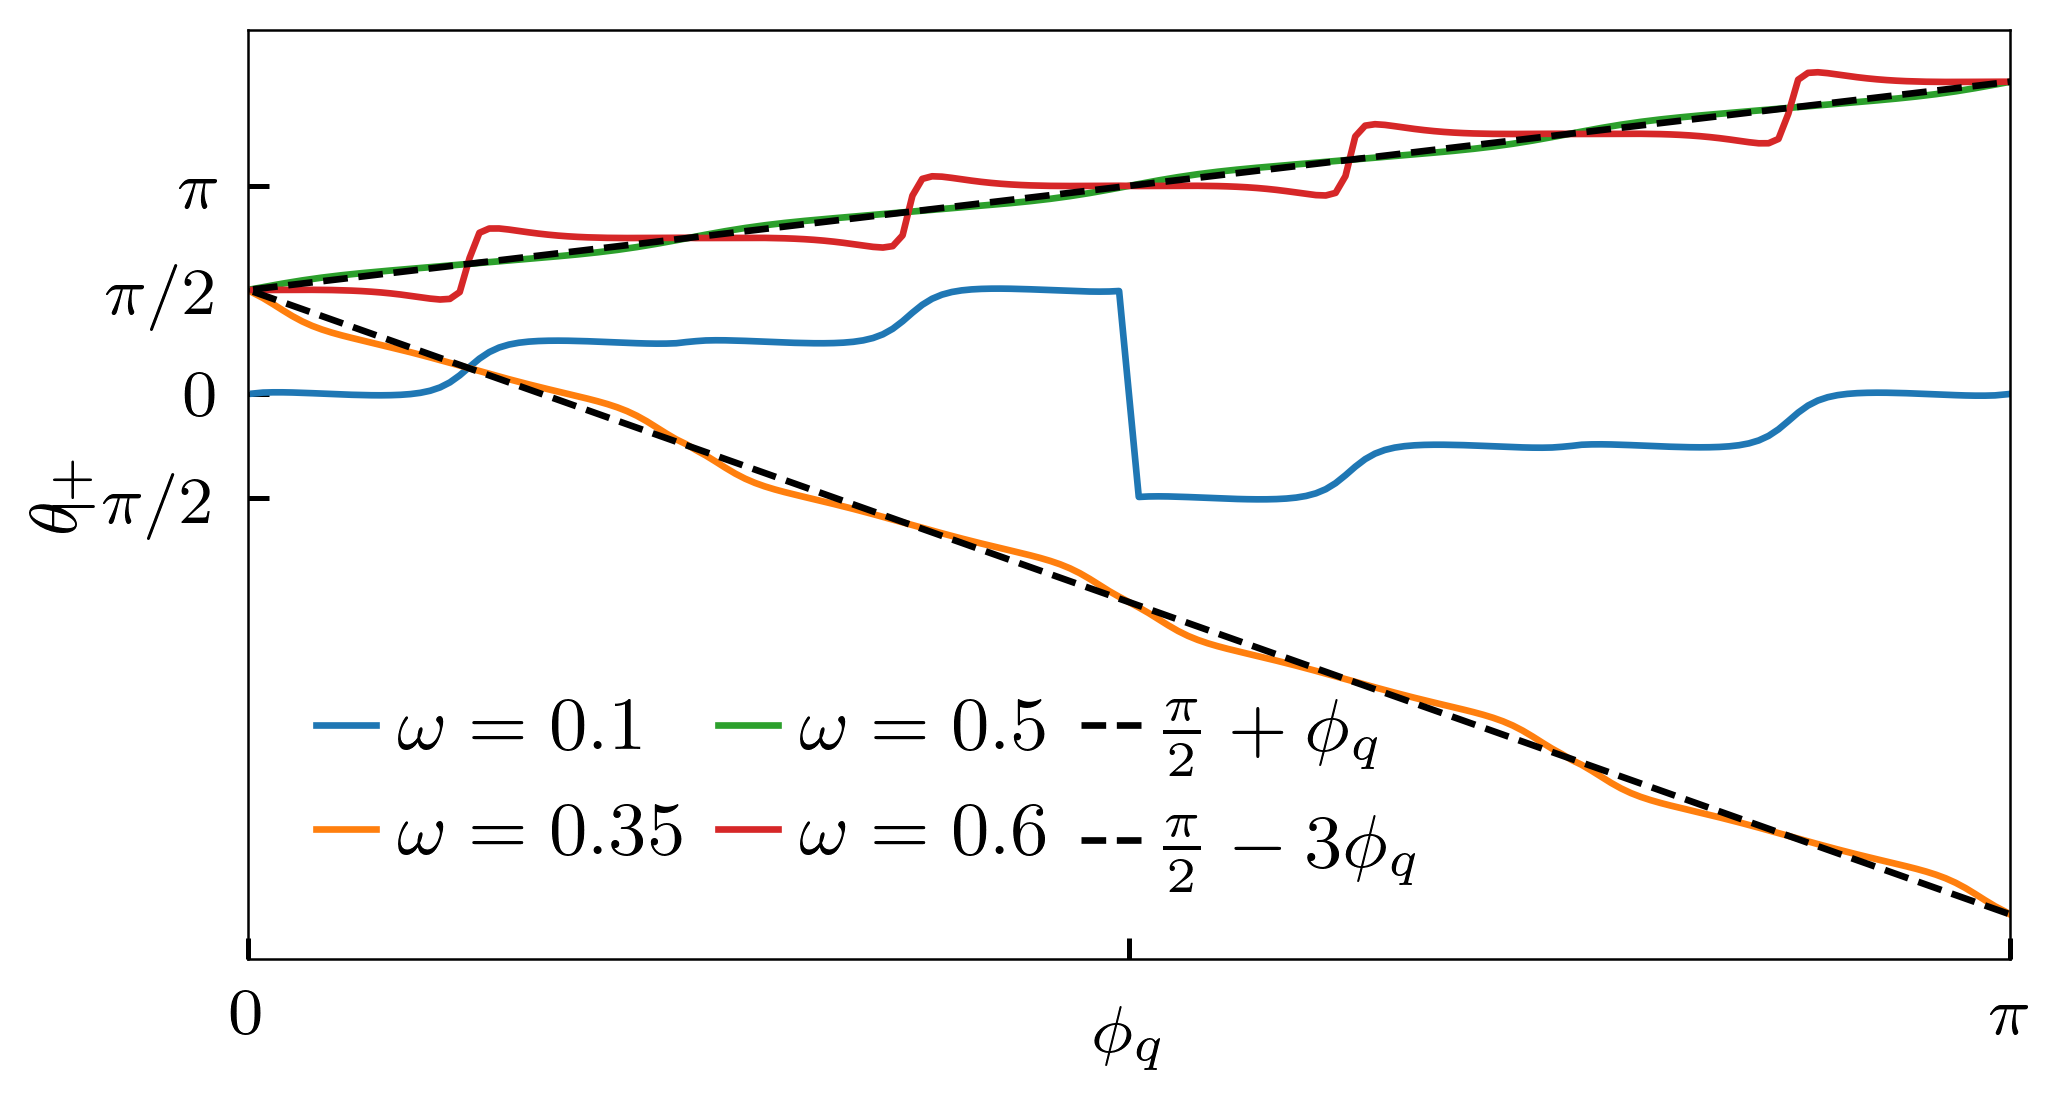

In [ ]:
theta_ana = np.pi/2 + phis

fig, ax = plt.subplots(figsize=(3.4, 1.8))

for omega0 in omega_list:
    ax.plot(phis, thetas_unw[omega0], marker="",  label=rf"$\omega={omega0}$")

ax.plot(phis, theta_ana,  marker="", ls="--", color="k", label=r"$\frac{\pi}{2}+\phi_q$")
ax.plot(phis, np.pi/2 - 3*phis,  marker="", ls="--", color="k", label=r"$\frac{\pi}{2}-3\phi_q$")

ax.set_xlim(0, np.pi)
ax.set_xticks([0, np.pi/2, np.pi], labels=[r"$0$", r"", r"$\pi$"])
ax.set_xlabel(r"$\phi_q$", labelpad=-5)

ax.set_ylabel(r"$\theta_+$", labelpad=-5)
ax.set_yticks([-np.pi/2, 0, np.pi / 2, np.pi], labels=[r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax.legend(ncols=3)

fig.tight_layout(pad=0.3)
fig.savefig("Fig7a-theta_plus_vs_phiq-gwave.svg")
fig.savefig("Fig7a-theta_plus_vs_phiq-gwave.pdf", dpi=1000)

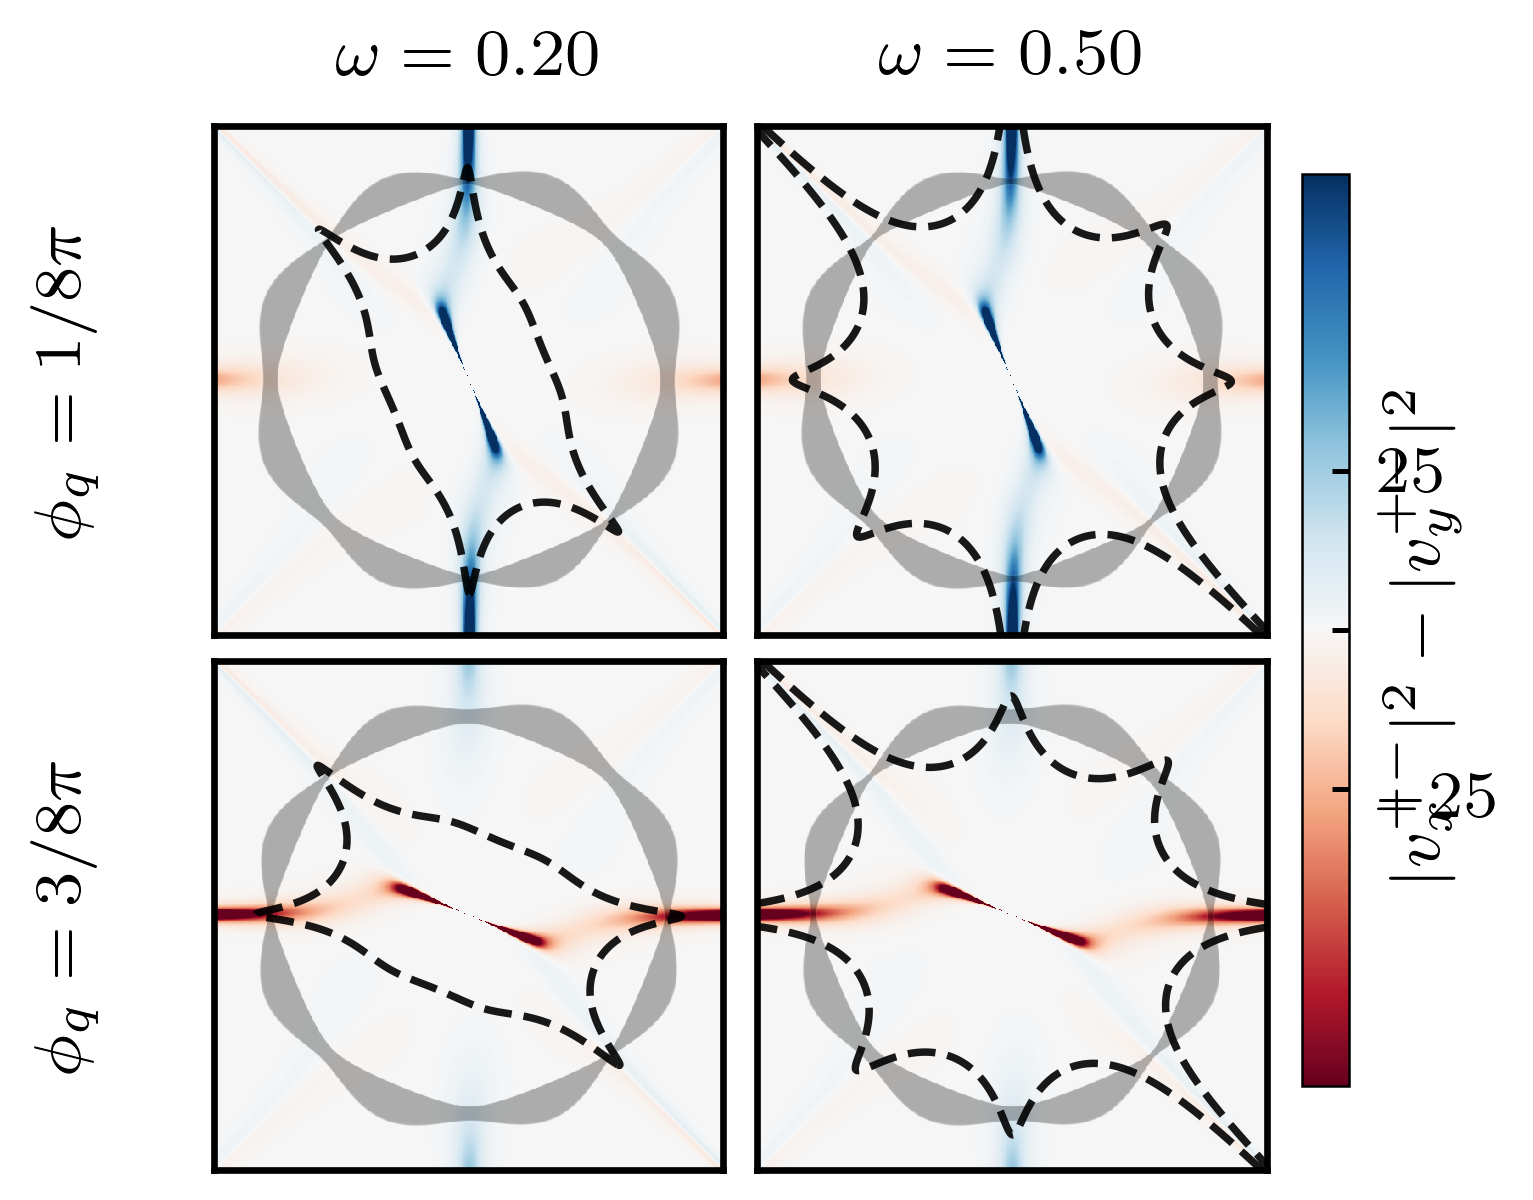

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_kubo_2x2_prb_onecol_simplified_with_pauli(
    *,
    q, omegas=(0.2, 0.4), phis=(np.pi/8, 3*np.pi/8),
    m=1.0, Kx=0.5, Kz=1.0, symmetry="d-wave",
    mu=0.0, T=0.01,
    kmax=np.pi, Nk=1001, eta_omega=0.02,
    use_helix_frame=False,
    aniso_mode="v",          # "v" or "kernel"
    resonance="contour",     # "contour" or "overlay" or "none"
    # resonance styling
    alpha_wk=0.35, wk_pow=0.8,
    lw_res=0.9,
    # Pauli overlay
    show_pauli=True,
    pauli_mode="mask",       # "mask" or "contour"
    occ_cut=0.05,
    pauli_floor=5e-3,
    alpha_pauli=0.35, pauli_pow=0.9,
    aniso_quantile=0.995,
    fontsize=8,
):
    mpl.rcParams.update({
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    })

    def compute_panel(phi_q, omega0):
        qx = q*np.cos(phi_q); qy = q*np.sin(phi_q)
        k = np.linspace(-kmax, kmax, Nk)
        KX, KY = np.meshgrid(k, k, indexing="xy")

        d1, d3, d1x, d1y, d3x, d3y = d_fields_np(
            KX, KY, Kx=Kx, Kz=Kz, qx=qx, qy=qy, symmetry=symmetry
        )
        R = np.sqrt(d1*d1 + d3*d3)
        gap = 2.0 * R

        vx = v_interband_np("x", d1, d3, d1x, d1y, d3x, d3y, R)
        vy = v_interband_np("y", d1, d3, d1x, d1y, d3x, d3y, R)

        if use_helix_frame:
            c, s = np.cos(phi_q), np.sin(phi_q)
            vA =  c*vx + s*vy
            vB = -s*vx + c*vy
            aniso_label = r"$|v_{\parallel}^{+-}|^2-|v_{\perp}^{+-}|^2$"
        else:
            vA, vB = vx, vy
            aniso_label = r"$|v_x^{+-}|^2-|v_y^{+-}|^2$"

        eps0 = (KX*KX + KY*KY + 0.25*(qx*qx + qy*qy)) / (2.0*m)
        E_minus = eps0 - R
        E_plus  = eps0 + R
        occ = _fermi_vec(E_minus, mu, T) - _fermi_vec(E_plus, mu, T)
        occ_abs = np.abs(occ)

        Wk = _kubo_weight_map(omega0=omega0, eta_omega=eta_omega, R=R)

        if aniso_mode == "v":
            A = (vA*vA) - (vB*vB)
        elif aniso_mode == "kernel":
            A = occ * ((vA*vA) - (vB*vB)) * Wk
        else:
            raise ValueError("aniso_mode must be 'v' or 'kernel'")

        return A, Wk, occ_abs, gap, aniso_label

    # order panels as (rows=phis, cols=omegas)
    panels = []
    for phi_q in phis:
        for omega0 in omegas:
            A, Wk, occ_abs, gap, label = compute_panel(phi_q, omega0)
            panels.append((phi_q, omega0, A, Wk, occ_abs, gap, label))

    all_abs = np.concatenate([np.abs(p[2]).ravel() for p in panels])
    halfr = float(np.nanquantile(all_abs, aniso_quantile))
    if not np.isfinite(halfr) or halfr <= 0:
        halfr = 1.0

    fig, axes = plt.subplots(
        len(phis), len(omegas),
        figsize=(2.6, 2.0),
        constrained_layout=False,
        sharex=True, sharey=True,
    )

    # ensure 2D array of axes
    axes = np.atleast_2d(axes)

    def draw(ax, *, phi_q, omega0, A, Wk, occ_abs, gap, label):
        im = ax.imshow(
            A, origin="lower",
            extent=[-kmax, kmax, -kmax, kmax],
            aspect="equal",
            cmap="RdBu",
            norm=mpl.colors.CenteredNorm(0.0, halfr),
            interpolation="nearest",
            zorder=-3,
        )

        # Resonance cue
        if resonance == "overlay":
            W1 = Wk / (np.max(Wk) + 1e-30)
            ax.imshow(
                W1, origin="lower",
                extent=[-kmax, kmax, -kmax, kmax],
                aspect="equal",
                cmap="Greys",
                alpha=alpha_wk * (W1**wk_pow),
                interpolation="nearest",
                zorder=-2,
            )
        elif resonance == "contour":
            Ny, Nx = gap.shape
            xs = np.linspace(-kmax, kmax, Nx)
            ys = np.linspace(-kmax, kmax, Ny)
            X, Y = np.meshgrid(xs, ys, indexing="xy")
            ax.contour(
                X, Y, gap,
                levels=[omega0],
                colors="k",
                linewidths=lw_res,
                linestyles="--",
                alpha=0.9,
                zorder=5,
            )
        elif resonance == "none":
            pass
        else:
            raise ValueError("resonance must be 'contour', 'overlay', or 'none'")

        # Pauli overlay
        if show_pauli:
            if pauli_mode == "mask":
                P = occ_abs / (np.max(occ_abs) + 1e-30)
                Pm = np.where(P > pauli_floor, P, np.nan)
                ax.imshow(
                    Pm, origin="lower",
                    extent=[-kmax, kmax, -kmax, kmax],
                    aspect="equal",
                    cmap="Greys",
                    alpha=alpha_pauli * (np.nan_to_num(Pm, nan=0.0)**pauli_pow),
                    interpolation="nearest",
                    zorder=-1,
                )
            elif pauli_mode == "contour":
                Ny, Nx = occ_abs.shape
                xs = np.linspace(-kmax, kmax, Nx)
                ys = np.linspace(-kmax, kmax, Ny)
                X, Y = np.meshgrid(xs, ys, indexing="xy")
                ax.contour(
                    X, Y, occ_abs,
                    levels=[occ_cut],
                    colors="k",
                    linewidths=0.8,
                    linestyles="-",
                    alpha=0.8,
                    zorder=6,
                )
            else:
                raise ValueError("pauli_mode must be 'mask' or 'contour'")

        ax.set_xticks([])
        ax.set_yticks([])
        for sp in ax.spines.values():
            sp.set_linewidth(0.8)

        return im, label

    im0, label0 = None, None
    for r, phi_q in enumerate(phis):
        for c, omega0 in enumerate(omegas):
            phi_q_, omega0_, A, Wk, occ_abs, gap, label = panels[r*len(omegas) + c]
            im, lab = draw(
                axes[r, c],
                phi_q=phi_q_, omega0=omega0_,
                A=A, Wk=Wk, occ_abs=occ_abs, gap=gap, label=label
            )
            if im0 is None:
                im0, label0 = im, lab

            # Column titles (omega on top)
            if r == 0:
                axes[r, c].set_title(rf"$\omega={omega0:.2f}$")

            # Row labels (phi_q on the left)
            if c == 0:
                axes[r, c].set_ylabel(rf"$\phi_q={int(phi_q/np.pi*8):d}/8\pi$",
                                      rotation=90, labelpad=18, va="center")

    # Adjust layout to make room for row labels + right colorbar
    fig.subplots_adjust(left=0.18, right=0.86, bottom=0.05, top=0.92,
                        wspace=0.05, hspace=0.05)

    # Colorbar on the right, spanning the grid height
    cax = fig.add_axes([0.88, 0.12, 0.03, 0.76])
    cbar = fig.colorbar(im0, cax=cax, orientation="vertical")
    cbar.ax.tick_params(direction="in", length=2)
    cbar.ax.set_yticks([-25, 0, 25], labels=[r"$-25$", r"", r"$25$"])

    # choose your ticks; keep symmetric
    cbar.set_ticks([-25, 0, 25])
    cbar.set_ticklabels([r"$-25$", r"", r"$25$"])
    cbar.set_label(label0, rotation=90, labelpad=-15)

    return fig, axes


# Example call:
fig, axes = plot_kubo_2x2_prb_onecol_simplified_with_pauli(
    q=q,
    omegas=(0.2, 0.5),
    phis=(np.pi/8, 3*np.pi/8),
    m=params["g-wave"]["m"],
    Kx=params["g-wave"]["Kx"],
    Kz=params["g-wave"]["Kz"],
    symmetry=params["g-wave"]["symmetry"],
    mu=params["g-wave"]["mu"],
    T=0.01,
    kmax=np.pi,
    Nk=601,
    eta_omega=params["g-wave"]["eta"],
    resonance="contour",
    show_pauli=True,
    pauli_mode="mask",
    alpha_pauli=0.30,
)
plt.show()
fig.savefig("Fig7b-kubo_anisotropy_with_pauli_gwave.svg")
fig.savefig("Fig7b-kubo_anisotropy_with_pauli_gwave.pdf", dpi=1000)
